<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/Mind_Mappers_Micropublication_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
# @title Install dependencies
!pip install numpy==1.23.5
!pip install nilearn actflow


  Using cached nilearn-0.11.1-py3-none-any.whl.metadata (9.3 kB)
  Using cached actflow-0.3.4-py3-none-any.whl.metadata (9.2 kB)
  Using cached gglasso-0.2.1-py3-none-any.whl.metadata (6.2 kB)
  Using cached wbplot-1.0.14-py3-none-any.whl.metadata (3.3 kB)
  Using cached numba-0.59.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
Using cached nilearn-0.11.1-py3-none-any.whl (10.5 MB)
Using cached actflow-0.3.4-py3-none-any.whl (54 kB)
Using cached gglasso-0.2.1-py3-none-any.whl (59 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.44.0
    Uninstalling llvmlite-0.44.0:
      Successfully u

In [ ]:
!pip install --upgrade setuptools

import os
import numpy as np
import matplotlib.pyplot as plt

# Necessary for visualization
from nilearn import plotting, datasets

import h5py
import pkg_resources
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

import ActflowToolbox as actflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.38.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.


<ipython-input-2-5541c21d8e7f>:11: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}


# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
# @title Download the data

# @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

import os, requests, tarfile

fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
  file_path=os.path.join(HCP_DIR, fname)

  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!


In [ ]:
# @title Extract the data in `HCP_DIR`
fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
  # open file
  path_name = os.path.join(HCP_DIR, fname)
  if not os.path.exists(path_name):
    print(f"Extracting {fname}.tgz...")
    with tarfile.open(f"{fname}.tgz") as fzip:
      fzip.extractall(HCP_DIR)
  else:
    print(f"File {fname}.tgz has already been extracted.")

Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

In [ ]:
networkdef = regions[1]
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [ ]:
with np.load(f"atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"   #file might have missing data
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

In [ ]:
hcp_rest_dir = os.path.join(HCP_DIR, "hcp_rest")
print("Available files in hcp_rest:", os.listdir(hcp_rest_dir))

Available files in hcp_rest: ['.DS_Store', '._subjects', '._.DS_Store', 'subjects', 'regions.npy']


In [ ]:
subjects_dir = os.path.join(HCP_DIR, "hcp_rest", "subjects")
print("Available subjects:", os.listdir(subjects_dir))

Available subjects: ['._266', '._21', '193', '._47', '192', '27', '._322', '295', '._260', '316', '230', '._214', '248', '166', '._114', '._191', '._151', '301', '320', '292', '62', '116', '124', '300', '190', '4', '194', '._2', '259', '32', '._57', '._300', '93', '284', '.DS_Store', '218', '201', '._88', '165', '._124', '322', '299', '112', '249', '._198', '._141', '241', '._42', '._261', '._89', '._90', '._158', '261', '._33', '39', '52', '._53', '296', '315', '._174', '6', '96', '._163', '._229', '._29', '7', '129', '._231', '._279', '._201', '._221', '._274', '._224', '._330', '152', '42', '._295', '51', '161', '242', '._134', '123', '._40', '120', '._319', '78', '99', '._92', '19', '219', '330', '._133', '._48', '1', '64', '._96', '._306', '._107', '140', '115', '325', '5', '256', '9', '272', '82', '252', '._307', '104', '._226', '._204', '._244', '._302', '10', '._97', '._203', '306', '66', '142', '0', '._200', '._162', '._50', '._156', '277', '61', '229', '65', '36', '318', '134

In [ ]:
subject_data_dir = os.path.join(subjects_dir, "318")  # Replace with an actual subject ID
print("Files in subject directory:", os.listdir(subject_data_dir))

Files in subject directory: ['.DS_Store', '._.DS_Store', '._timeseries', 'timeseries']


In [ ]:
hcp_dir = "./DATA/hcp_rest"
subject_id = "318"  # example subject id
timeseries_dir = os.path.join(hcp_dir, "subjects", subject_id, "timeseries")

# Print available files to confirm they exist
print("Files in timeseries directory:", os.listdir(timeseries_dir))

# Specify the correct file path
file_path = os.path.join(timeseries_dir, "bold1_Atlas_MSMAll_Glasser360Cortical.npy")

# Load the data
bold_data = np.load(file_path)
print("Functional data shape:", bold_data.shape)


Files in timeseries directory: ['bold2_Atlas_MSMAll_Glasser360Cortical.npy', 'bold1_Atlas_MSMAll_Glasser360Cortical.npy', 'bold4_Atlas_MSMAll_Glasser360Cortical.npy', 'bold3_Atlas_MSMAll_Glasser360Cortical.npy']
Functional data shape: (360, 1200)


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List all files in your root Google Drive folder
os.listdir("/content/drive/MyDrive/")

['Colab Notebooks',
 'HCP_1200_processed',
 'hcp1200_subjects.txt',
 'CC200_ROI_labels.csv',
 'CC200.nii',
 'glasser360MNI.nii',
 'glasser360MNI_resampled.nii',
 'glasser_resampled_to_craddock.nii.gz',
 'Craddock_Social_Cognition',
 'glasser_to_craddock_mapping.npy',
 'task_data_craddock',
 'task_data_voxel_space',
 'resting_state_craddock',
 'preprocessed_dataset',
 'cc200_roi_atlas.nii']

In [ ]:
hcp_rest_dir = "./DATA/hcp_rest"  # Make sure this is the correct directory

if os.path.exists(hcp_rest_dir):
    files = os.listdir(hcp_rest_dir)
    print("Available files in hcp_rest:", files)
else:
  print(f"Directory not found: {hcp_rest_dir}")


Available files in hcp_rest: ['.DS_Store', '._subjects', '._.DS_Store', 'subjects', 'regions.npy']


In [ ]:
subjects_dir = "./DATA/hcp_rest/subjects"

if os.path.exists(subjects_dir):
    subjects_files = os.listdir(subjects_dir)
    print("Available files in subjects directory:", subjects_files)
else:
    print(f"Directory not found: {subjects_dir}")

Available files in subjects directory: ['._266', '._21', '193', '._47', '192', '27', '._322', '295', '._260', '316', '230', '._214', '248', '166', '._114', '._191', '._151', '301', '320', '292', '62', '116', '124', '300', '190', '4', '194', '._2', '259', '32', '._57', '._300', '93', '284', '.DS_Store', '218', '201', '._88', '165', '._124', '322', '299', '112', '249', '._198', '._141', '241', '._42', '._261', '._89', '._90', '._158', '261', '._33', '39', '52', '._53', '296', '315', '._174', '6', '96', '._163', '._229', '._29', '7', '129', '._231', '._279', '._201', '._221', '._274', '._224', '._330', '152', '42', '._295', '51', '161', '242', '._134', '123', '._40', '120', '._319', '78', '99', '._92', '19', '219', '330', '._133', '._48', '1', '64', '._96', '._306', '._107', '140', '115', '325', '5', '256', '9', '272', '82', '252', '._307', '104', '._226', '._204', '._244', '._302', '10', '._97', '._203', '306', '66', '142', '0', '._200', '._162', '._50', '._156', '277', '61', '229', '65'

In [ ]:
timeseries_dir = "./DATA/hcp_rest/subjects/318/timeseries"

if os.path.exists(timeseries_dir):
    timeseries_files = os.listdir(timeseries_dir)
    print("Available files in timeseries directory:", timeseries_files)
else:
    print(f"Directory not found: {timeseries_dir}")


Available files in timeseries directory: ['bold2_Atlas_MSMAll_Glasser360Cortical.npy', 'bold1_Atlas_MSMAll_Glasser360Cortical.npy', 'bold4_Atlas_MSMAll_Glasser360Cortical.npy', 'bold3_Atlas_MSMAll_Glasser360Cortical.npy']


# HCP glasser (360) to Craddock (200) conversion

### **Rest data**

Here are the links to access the following files:

[Glasser_to_craddock_mapping,npy](https://drive.google.com/file/d/1--nUf0C7IZ66J9jxKeSlhyjlQjMfhZvE/view?usp=share_link)

[Resting_state_craddock files](https://drive.google.com/drive/folders/1KTnpSx5JvZGYg8BUPURSTXnllhJOxNJr?usp=share_link)

In [ ]:

# Load the precomputed Glasser-to-Craddock mapping
mapping_path = "/content/drive/MyDrive/glasser_to_craddock_mapping.npy"
glasser_to_craddock_mapping = np.load(mapping_path, allow_pickle=True).item()

# Define HCP resting-state data directory
hcp_rest_dir = "./DATA/hcp_rest/subjects"

# Set Google Drive Save Directory
save_dir = "/content/drive/MyDrive/resting_state_craddock"  # Save all transformed data here
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

# Get list of valid subject IDs (numeric-only folders)
subject_ids = sorted([s for s in os.listdir(hcp_rest_dir) if s.isdigit()])
print(f"Found {len(subject_ids)} subjects.")

# Process each subject:
for subject in subject_ids:
    print(f"Processing subject {subject}...")

    # Collect all resting-state runs (bold1, bold2, bold3, bold4)
    bold_files = [f"bold{i}_Atlas_MSMAll_Glasser360Cortical.npy" for i in range(1, 5)]
    bold_paths = [os.path.join(hcp_rest_dir, subject, "timeseries", file) for file in bold_files]

    # Check if all bold files exist
    missing_files = [p for p in bold_paths if not os.path.exists(p)]
    if missing_files:
        print(f"Missing files for subject {subject}: {missing_files}. Skipping.")
        continue

    # Load and concatenate all resting-state runs
    glasser_timeseries_list = [np.load(p) for p in bold_paths]
    glasser_timeseries = np.concatenate(glasser_timeseries_list, axis=1)  # (360, 4800)
    n_timepoints = glasser_timeseries.shape[1]

    print(f"Subject {subject} Resting-State Time Series Shape: {glasser_timeseries.shape}")  # Expected (360, 4800)

    # Initialize Craddock time series (200 x Timepoints)
    craddock_timeseries = np.zeros((200, n_timepoints), dtype=np.float32)

    # Apply Glasser → Craddock mapping
    for cr_roi, glasser_rois in glasser_to_craddock_mapping.items():
        valid_glasser_rois = np.array(glasser_rois, dtype=int) - 1  # Convert to zero-based indices
        if valid_glasser_rois.size > 0:
            craddock_timeseries[cr_roi - 1, :] = np.mean(glasser_timeseries[valid_glasser_rois, :], axis=0)

    # Save transformed Craddock time series directly to Google Drive
    output_path = os.path.join(save_dir, f"sub-{subject}_REST_Craddock200.npy")
    np.save(output_path, craddock_timeseries)
    print(f"Saved transformed Craddock data for subject {subject} at {output_path}")

print("All subjects processed for Resting-State fMRI!")

Found 339 subjects.
Processing subject 0...
Subject 0 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 0 at /content/drive/MyDrive/resting_state_craddock/sub-0_REST_Craddock200.npy
Processing subject 1...
Subject 1 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 1 at /content/drive/MyDrive/resting_state_craddock/sub-1_REST_Craddock200.npy
Processing subject 10...
Subject 10 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 10 at /content/drive/MyDrive/resting_state_craddock/sub-10_REST_Craddock200.npy
Processing subject 100...
Subject 100 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 100 at /content/drive/MyDrive/resting_state_craddock/sub-100_REST_Craddock200.npy
Processing subject 101...
Subject 101 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 101 at /content/drive/MyDrive/resting

In [ ]:
#RESAMPLED GLASSER TO MATCH CRADDOCK
from nilearn.image import resample_to_img
import nibabel as nib

# Paths to volumetric atlases
glasser_path = "/content/drive/MyDrive/glasser360MNI.nii"
craddock_path = "/content/drive/MyDrive/CC200.nii"

# Load images
glasser_img = nib.load(glasser_path)
craddock_img = nib.load(craddock_path)

# Resample Glasser to match Craddock's resolution
glasser_resampled = resample_to_img(glasser_img, craddock_img, interpolation='nearest')

# Save the resampled Glasser atlas
glasser_resampled_path = "/content/drive/MyDrive/glasser360MNI_resampled.nii"
nib.save(glasser_resampled, glasser_resampled_path)

print(f"Resampled Glasser atlas saved at: {glasser_resampled_path}")

<ipython-input-22-849388a1337b>:14: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  glasser_resampled = resample_to_img(glasser_img, craddock_img, interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Resampled Glasser atlas saved at: /content/drive/MyDrive/glasser360MNI_resampled.nii


In [ ]:
glasser_data = glasser_resampled.get_fdata().astype(int)
craddock_data = craddock_img.get_fdata().astype(int)

print("Glasser Resampled Shape:", glasser_data.shape)
print("Craddock Shape:", craddock_data.shape)

Glasser Resampled Shape: (63, 75, 61)
Craddock Shape: (63, 75, 61)


In [ ]:
# BUILD VOXEL WISE ROI MAPPING
# Get unique Craddock ROIs (ignore background 0)
unique_craddock_rois = np.unique(craddock_data[craddock_data > 0])
roi_mapping = {}

# Map each Craddock voxel to Glasser ROIs
for cr_roi in unique_craddock_rois:
    mask = (craddock_data == cr_roi)
    mapped_labels = np.unique(glasser_data[mask])
    mapped_labels = mapped_labels[mapped_labels > 0]  # Remove background
    roi_mapping[int(cr_roi)] = mapped_labels.tolist()

# Print sample mappings
for cr_roi in sorted(roi_mapping.keys())[:200]:
    print(f"Craddock ROI {cr_roi}: Mapped Glasser ROIs {roi_mapping[cr_roi]}")

# Save for later use
np.save("/content/drive/MyDrive/glasser_to_craddock_mapping.npy", roi_mapping)

Craddock ROI 1: Mapped Glasser ROIs [185, 186, 200, 201, 336, 338, 339]
Craddock ROI 2: Mapped Glasser ROIs [203, 208, 320, 321, 323, 329, 330, 331]
Craddock ROI 3: Mapped Glasser ROIs [1, 3, 4, 5, 15, 30, 31, 142, 161]
Craddock ROI 4: Mapped Glasser ROIs [204, 283, 286, 287, 347, 348, 353, 358]
Craddock ROI 5: Mapped Glasser ROIs [241, 242, 244, 245, 249, 252, 359, 360]
Craddock ROI 6: Mapped Glasser ROIs [8, 27, 32, 35, 36, 37, 38, 40, 161, 162]
Craddock ROI 7: Mapped Glasser ROIs [144, 148, 149]
Craddock ROI 8: Mapped Glasser ROIs [188, 189, 190, 231, 232, 233, 234]
Craddock ROI 9: Mapped Glasser ROIs [185, 343]
Craddock ROI 10: Mapped Glasser ROIs [18]
Craddock ROI 11: Mapped Glasser ROIs [304, 305, 308, 309, 310, 312, 313, 319, 355, 356, 357]
Craddock ROI 12: Mapped Glasser ROIs [77, 89, 90, 91, 170]
Craddock ROI 13: Mapped Glasser ROIs [26, 40, 41, 43, 57, 59, 60, 63, 179, 206, 223, 243]
Craddock ROI 14: Mapped Glasser ROIs [25, 28, 139, 140, 143, 148, 149, 150, 151]
Craddock ROI

In [ ]:
print(f"Total Craddock ROIs mapped: {len(roi_mapping)}")

Total Craddock ROIs mapped: 200


In [ ]:
#TRANSFORM RS TIME SERIES
# Load the precomputed mapping
mapping_path = "/content/drive/MyDrive/glasser_to_craddock_mapping.npy"
glasser_to_craddock_mapping = np.load(mapping_path, allow_pickle=True).item()

# Define directory for HCP Resting-State Data
hcp_rest_dir = "./DATA/hcp_rest/subjects"

# Get list of valid subjects
subject_ids = sorted([s for s in os.listdir(hcp_rest_dir) if s.isdigit()])
print(f"Found {len(subject_ids)} subjects.")

# Process each subject
for subject in subject_ids:
    rest_ts_paths = [
        os.path.join(hcp_rest_dir, subject, "timeseries", f"bold{i}_Atlas_MSMAll_Glasser360Cortical.npy")
        for i in range(1, 5)  # BOLD1, BOLD2, BOLD3, BOLD4
    ]

    # Check if all runs exist
    missing_files = [p for p in rest_ts_paths if not os.path.exists(p)]
    if missing_files:
        print(f"Missing resting-state files for subject {subject}. Skipping.")
        continue

    print(f"Processing subject {subject}...")

    # Load and concatenate all 4 BOLD runs
    glasser_timeseries = np.concatenate([np.load(p) for p in rest_ts_paths], axis=1)

    # Initialize Craddock time series array
    n_timepoints = glasser_timeseries.shape[1]
    craddock_timeseries = np.zeros((200, n_timepoints), dtype=np.float32)

    # Apply Glasser → Craddock mapping
    for cr_roi in range(1, 201):
        mapped_glasser_rois = np.array(glasser_to_craddock_mapping.get(cr_roi, []), dtype=int)

        if mapped_glasser_rois.size > 0:
            valid_indices = mapped_glasser_rois - 1
            craddock_timeseries[cr_roi - 1, :] = np.mean(glasser_timeseries[valid_indices, :], axis=0)

    # Save transformed Craddock time series
    output_path = f"/content/drive/MyDrive/resting_state_craddock/sub-{subject}_Craddock200.npy"
    np.save(output_path, craddock_timeseries)
    print(f"Saved transformed Craddock data for subject {subject} at {output_path}")

print("All subjects processed for resting-state data!")

Found 339 subjects.
Processing subject 0...
Saved transformed Craddock data for subject 0 at /content/drive/MyDrive/resting_state_craddock/sub-0_Craddock200.npy
Processing subject 1...
Saved transformed Craddock data for subject 1 at /content/drive/MyDrive/resting_state_craddock/sub-1_Craddock200.npy
Processing subject 10...
Saved transformed Craddock data for subject 10 at /content/drive/MyDrive/resting_state_craddock/sub-10_Craddock200.npy
Processing subject 100...
Saved transformed Craddock data for subject 100 at /content/drive/MyDrive/resting_state_craddock/sub-100_Craddock200.npy
Processing subject 101...
Saved transformed Craddock data for subject 101 at /content/drive/MyDrive/resting_state_craddock/sub-101_Craddock200.npy
Processing subject 102...
Saved transformed Craddock data for subject 102 at /content/drive/MyDrive/resting_state_craddock/sub-102_Craddock200.npy
Processing subject 103...
Saved transformed Craddock data for subject 103 at /content/drive/MyDrive/resting_state

In [ ]:
sample_subject_path = "/content/drive/MyDrive/resting_state_craddock/sub-99_Craddock200.npy"
craddock_timeseries = np.load(sample_subject_path)

print(f"Loaded {sample_subject_path} with shape: {craddock_timeseries.shape}")  # Expected: (200, 4800)
print(f"Mean Activation (Craddock): {np.mean(craddock_timeseries)}")

Loaded /content/drive/MyDrive/resting_state_craddock/sub-99_Craddock200.npy with shape: (200, 4800)
Mean Activation (Craddock): 10219.318359375


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


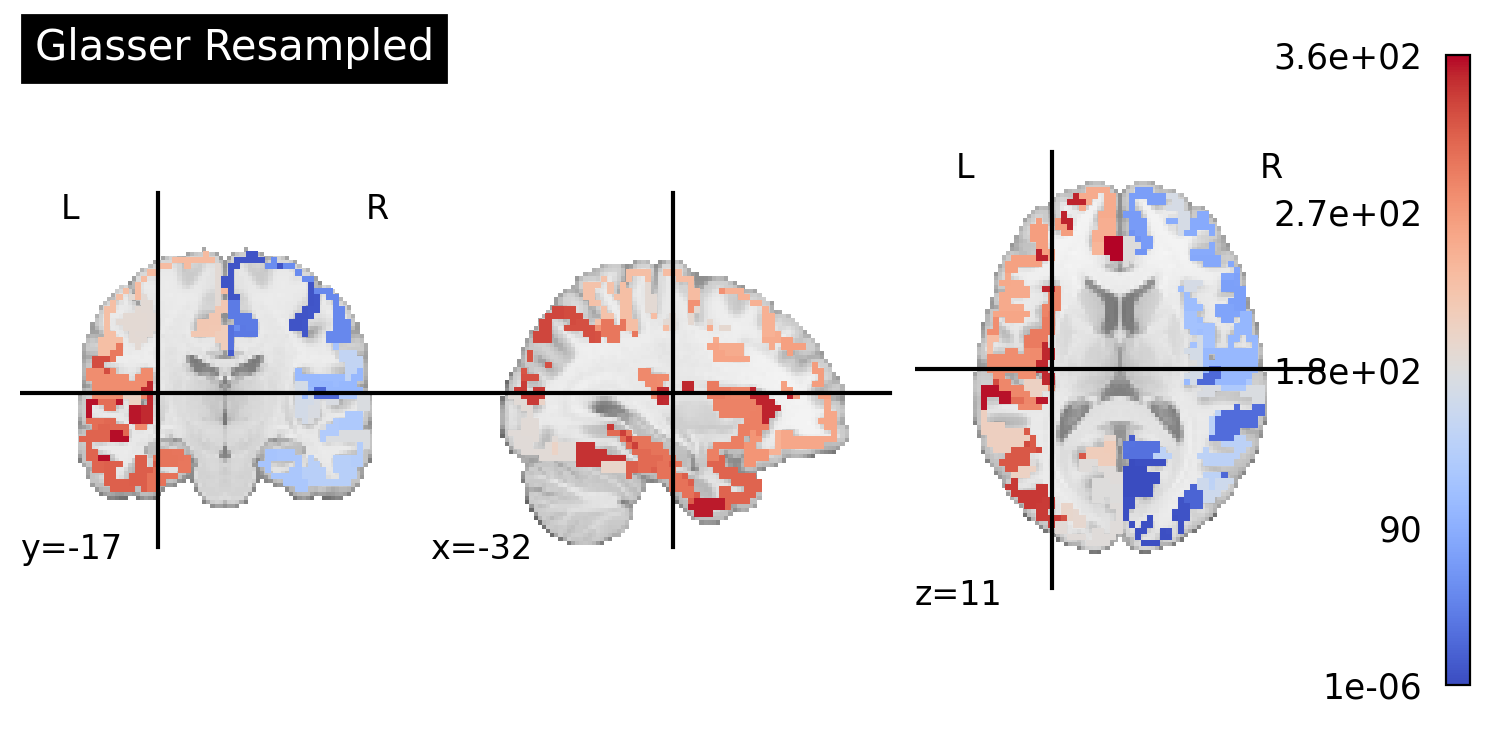

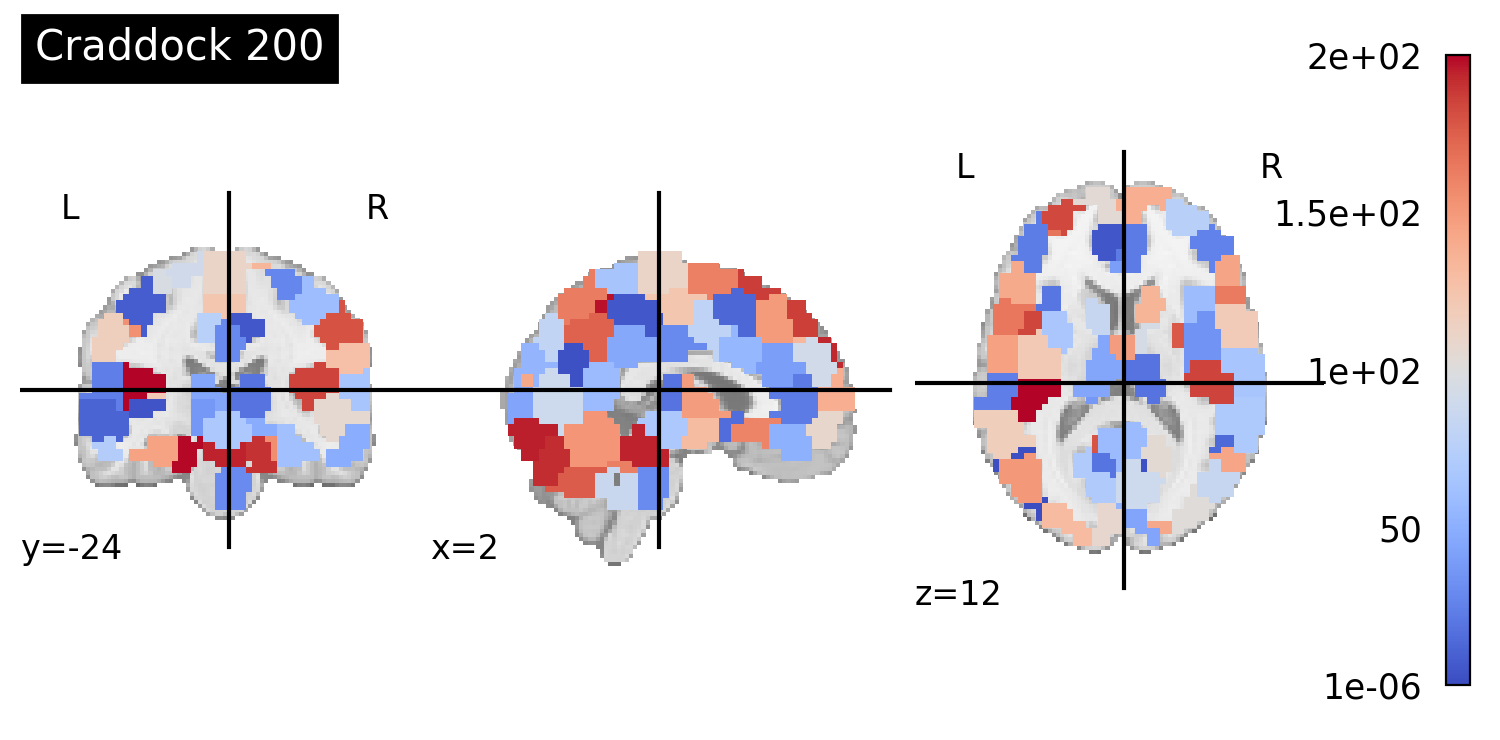

In [ ]:
from nilearn.plotting import plot_stat_map

plot_stat_map(glasser_resampled, title="Glasser Resampled",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

plot_stat_map(craddock_img, title="Craddock 200",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

### **Task data**

In [ ]:
#verifying path
# Path to HCP task data directory
hcp_task_path = "./DATA/hcp_task/subjects"

# Check if the directory exists
if os.path.exists(hcp_task_path):
    print("Task data directory found. Listing files...")
    print(os.listdir(hcp_task_path))
else:
    print("Task data directory NOT found. Check if the data is extracted properly.")


Task data directory found. Listing files...
['._266', '._21', '193', '._47', '192', '27', '._322', '295', '._260', '316', '230', '._214', '248', '166', '._114', '._191', '._151', '301', '320', '292', '62', '116', '124', '300', '190', '4', '194', '._2', '259', '32', '._57', '._300', '93', '284', '.DS_Store', '218', '201', '._88', '165', '._124', '322', '299', '112', '249', '._198', '._141', '241', '._42', '._261', '._89', '._90', '._158', '261', '._33', '39', '52', '._53', '296', '315', '._174', '6', '96', '._163', '._229', '._29', '7', '129', '._231', '._279', '._201', '._221', '._274', '._224', '._330', '152', '42', '._295', '51', '161', '242', '._134', '123', '._40', '120', '._319', '78', '99', '._92', '19', '219', '330', '._133', '._48', '1', '64', '._96', '._306', '._107', '140', '115', '325', '5', '256', '9', '272', '82', '252', '._307', '104', '._226', '._204', '._244', '._302', '10', '._97', '._203', '306', '66', '142', '0', '._200', '._162', '._50', '._156', '277', '61', '229',

In [ ]:
#checking subject folder
subject_id = "92"
subject_task_path = os.path.join("./DATA/hcp_task/subjects", subject_id)

if os.path.exists(subject_task_path):
    print(f"Subject {subject_id} task data found. Listing files...")
    print(os.listdir(subject_task_path))
else:
    print(f"No task data found for subject {subject_id}. Check directory structure.")


Subject 92 task data found. Listing files...
['.DS_Store', 'EVs', '._EVs', '._.DS_Store', '._timeseries', 'timeseries']


In [ ]:
timeseries_path = os.path.join("./DATA/hcp_task/subjects", "318", "timeseries")  # Replace 318 with another valid subject if needed

if os.path.exists(timeseries_path):
    print("Found timeseries folder. Available files:", os.listdir(timeseries_path))
else:
    print("No timeseries folder found for task data. Check data extraction.")


Found timeseries folder. Available files: ['bold7_Atlas_MSMAll_Glasser360Cortical.npy', 'bold17_Atlas_MSMAll_Glasser360Cortical.npy', 'bold15_Atlas_MSMAll_Glasser360Cortical.npy', 'bold18_Atlas_MSMAll_Glasser360Cortical.npy', 'bold9_Atlas_MSMAll_Glasser360Cortical.npy', 'bold16_Atlas_MSMAll_Glasser360Cortical.npy', 'bold10_Atlas_MSMAll_Glasser360Cortical.npy', 'bold6_Atlas_MSMAll_Glasser360Cortical.npy', 'bold14_Atlas_MSMAll_Glasser360Cortical.npy', 'bold11_Atlas_MSMAll_Glasser360Cortical.npy', 'bold12_Atlas_MSMAll_Glasser360Cortical.npy', 'bold5_Atlas_MSMAll_Glasser360Cortical.npy', 'bold8_Atlas_MSMAll_Glasser360Cortical.npy', 'bold13_Atlas_MSMAll_Glasser360Cortical.npy']


In [ ]:
# List all bold files found
bold_files = os.listdir(timeseries_path)

# Check if any file corresponds to SOCIAL task
social_task_files = [file for file in bold_files if "bold" in file and any(x in file for x in ["15", "16"])] # Adjust these numbers if needed

if social_task_files:
    print(f"Found potential Social Cognition task files: {social_task_files}")
else:
    print("No specific task file identified. Need to check task-condition mapping.")


Found potential Social Cognition task files: ['bold15_Atlas_MSMAll_Glasser360Cortical.npy', 'bold16_Atlas_MSMAll_Glasser360Cortical.npy']


In [ ]:
#loading task based FC data
# Define file paths
social_task_file1 = os.path.join(timeseries_path, "bold15_Atlas_MSMAll_Glasser360Cortical.npy")
social_task_file2 = os.path.join(timeseries_path, "bold16_Atlas_MSMAll_Glasser360Cortical.npy")

# Loading both runs
social_task_data1 = np.load(social_task_file1)
social_task_data2 = np.load(social_task_file2)

# Printing shape for verification
print(f"Loaded Social Cognition Task Data (Run 1): {social_task_data1.shape}")  # Expected: (360, Timepoints)
print(f"Loaded Social Cognition Task Data (Run 2): {social_task_data2.shape}")  # Expected: (360, Timepoints)


Loaded Social Cognition Task Data (Run 1): (360, 232)
Loaded Social Cognition Task Data (Run 2): (360, 232)


In [ ]:
hcp_task_dir = "./DATA/hcp_task/subjects"

# List only valid numeric subject directories (ignoring system files)
subject_ids = sorted([s for s in os.listdir(hcp_task_dir) if s.isdigit()])

print(f"Found {len(subject_ids)} valid subjects.")

Found 339 valid subjects.


In [ ]:
# Pick a sample subject from the filtered list
sample_subject = subject_ids[0]  # First valid subject
run1_path = os.path.join(hcp_task_dir, sample_subject, "timeseries", "bold15_Atlas_MSMAll_Glasser360Cortical.npy")
run2_path = os.path.join(hcp_task_dir, sample_subject, "timeseries", "bold16_Atlas_MSMAll_Glasser360Cortical.npy")

# Check if both task runs exist
if os.path.exists(run1_path) and os.path.exists(run2_path):
    print(f"Both runs exist for subject {sample_subject}")
    run1_timeseries = np.load(run1_path)
    run2_timeseries = np.load(run2_path)
    print(f"Run 1 Shape: {run1_timeseries.shape}, Run 2 Shape: {run2_timeseries.shape}")

else:
    print(f"Missing one or both runs for subject {sample_subject}. Check filenames and paths.")

Both runs exist for subject 0
Run 1 Shape: (360, 232), Run 2 Shape: (360, 232)


Access files for the code here:

[glasser360MNI.nii](https://drive.google.com/file/d/1a3ifHYCe3cmLRAVdvnXbSBp5M-MqFV72/view?usp=share_link)

[CC200.nii](https://drive.google.com/file/d/1ow_F1qui9lGN7wN3XHhBsGrQAaVpv-FF/view?usp=share_link)

[glasser_resampled_to_craddock.nii.gz](https://drive.google.com/file/d/1-5zk0isVZWk7DatO8KKAZqMC31P5aDhg/view?usp=share_link)

In [ ]:
#RESAMPLE GLASSER VOLUMETRIC ATLAS TO MATCH CRADDOCK ATLAS
from nilearn.image import resample_to_img

# Define file paths
glasser_mni_path = "/content/drive/MyDrive/glasser360MNI.nii"  # The volumetric Glasser
craddock_mni_path = "/content/drive/MyDrive/CC200.nii"  # The Craddock atlas

# Load the images
glasser_mni = nib.load(glasser_mni_path)
craddock_mni = nib.load(craddock_mni_path)

# Resample Glasser to match Craddock resolution
glasser_resampled = resample_to_img(glasser_mni, craddock_mni, interpolation='nearest')

# Save the resampled file
resampled_glasser_path = "/content/drive/MyDrive/glasser_resampled_to_craddock.nii.gz"
nib.save(glasser_resampled, resampled_glasser_path)

print(f"Glasser volumetric atlas resampled and saved at {resampled_glasser_path}")

<ipython-input-36-92268adf4dd2>:13: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  glasser_resampled = resample_to_img(glasser_mni, craddock_mni, interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Glasser volumetric atlas resampled and saved at /content/drive/MyDrive/glasser_resampled_to_craddock.nii.gz


In [ ]:
#VERIFY ALIGNMENT
# Load data
glasser_data = glasser_resampled.get_fdata()
craddock_data = nib.load(craddock_mni_path).get_fdata()

# Compare shapes
print(f"Glasser Resampled Shape: {glasser_data.shape}")
print(f"Craddock Shape: {craddock_data.shape}")

# Check voxel-wise overlap
overlap_voxels = np.sum((glasser_data > 0) & (craddock_data > 0))
print(f"Overlapping Voxels: {overlap_voxels}")

if overlap_voxels > 0:
    print("Glasser and Craddock are correctly aligned in MNI space")
else:
    print("No overlap found. Check resampling and alignment.")

Glasser Resampled Shape: (63, 75, 61)
Craddock Shape: (63, 75, 61)
Overlapping Voxels: 21517
Glasser and Craddock are correctly aligned in MNI space


In [ ]:
#COMPUTING VOXEL WISE ROI MAPPING (Glasser → Craddock)
# Extract voxel data arrays
glasser_voxels = glasser_resampled.get_fdata().astype(int)
craddock_voxels = nib.load(craddock_mni_path).get_fdata().astype(int)

# Compute mapping
roi_mapping = {}
unique_craddock_rois = np.unique(craddock_voxels[craddock_voxels > 0])

for cr_roi in unique_craddock_rois:
    mask = (craddock_voxels == cr_roi)
    mapped_labels = np.unique(glasser_voxels[mask])
    mapped_labels = mapped_labels[mapped_labels > 0]  # Remove background
    roi_mapping[cr_roi] = mapped_labels.tolist()

# Save mapping
np.save("/content/drive/MyDrive/glasser_to_craddock_mapping.npy", roi_mapping)

print("ROI Mapping Completed!")

ROI Mapping Completed!


In [ ]:
#TRANSFORM TIME SERIES DATA
SAVE_DIR = "/content/drive/MyDrive/Craddock_Social_Cognition"
os.makedirs(SAVE_DIR, exist_ok=True)  # Ensure directory exists

# Load the precomputed mapping
mapping_path = "/content/drive/MyDrive/glasser_to_craddock_mapping.npy"
glasser_to_craddock_mapping = np.load(mapping_path, allow_pickle=True).item()

# Path to the Glasser ROI-based time series
hcp_task_dir = "./DATA/hcp_task/subjects"
subject_ids = sorted([s for s in os.listdir(hcp_task_dir) if s.isdigit()])
print(f"Found {len(subject_ids)} subjects.")

for subject in subject_ids:
    run1_path = os.path.join(hcp_task_dir, subject, "timeseries", "bold15_Atlas_MSMAll_Glasser360Cortical.npy")
    run2_path = os.path.join(hcp_task_dir, subject, "timeseries", "bold16_Atlas_MSMAll_Glasser360Cortical.npy")

    if not os.path.exists(run1_path) or not os.path.exists(run2_path):
        print(f"Missing Social Cognition task data for subject {subject}. Skipping.")
        continue  # Skip this subject

    print(f"Processing subject {subject}...")

    # Load both runs and concatenate
    run1_timeseries = np.load(run1_path)
    run2_timeseries = np.load(run2_path)
    social_task_timeseries = np.concatenate([run1_timeseries, run2_timeseries], axis=1)

    print(f" {subject} Concatenated Time Series Shape: {social_task_timeseries.shape}")

    # Initialize Craddock time series
    n_timepoints = social_task_timeseries.shape[1]
    craddock_timeseries = np.zeros((200, n_timepoints), dtype=np.float32)

    # Apply Glasser → Craddock mapping
    for cr_roi in range(1, 201):
        mapped_glasser_rois = np.array(glasser_to_craddock_mapping.get(cr_roi, []), dtype=int)

        if mapped_glasser_rois.size > 0:
            valid_indices = mapped_glasser_rois - 1  # Convert to zero-based indexing
            craddock_timeseries[cr_roi - 1, :] = np.mean(social_task_timeseries[valid_indices, :], axis=0)

    # **Save transformed Craddock time series in Google Drive**
    output_path = os.path.join(SAVE_DIR, f"sub-{subject}_SOCIAL_Craddock200.npy")
    np.save(output_path, craddock_timeseries)
    print(f"Saved transformed Craddock data for subject {subject} at {output_path}")

print("All subjects processed for Social Cognition task and saved to Google Drive!")

Found 339 subjects.
Processing subject 0...
 0 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 0 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-0_SOCIAL_Craddock200.npy
Processing subject 1...
 1 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 1 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-1_SOCIAL_Craddock200.npy
Processing subject 10...
 10 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 10 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-10_SOCIAL_Craddock200.npy
Processing subject 100...
 100 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 100 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-100_SOCIAL_Craddock200.npy
Processing subject 101...
 101 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 101 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-10

In [ ]:
# Verify transformation for subjects

# Define the path to the saved Craddock-transformed data
craddock_dir = "/content/drive/MyDrive/Craddock_Social_Cognition"

# List all transformed files
craddock_files = sorted([f for f in os.listdir(craddock_dir) if f.endswith("Craddock200.npy")])
print(f"Found {len(craddock_files)} transformed Craddock time series.")

# Select a sample subject to check
sample_subject_file = os.path.join(craddock_dir, craddock_files[0])
craddock_timeseries = np.load(sample_subject_file)

# Compute Mean Activation
mean_craddock = np.mean(craddock_timeseries)
nonzero_voxels = np.count_nonzero(craddock_timeseries)

print(f"Mean Activation (Craddock): {mean_craddock}")
print(f"Nonzero Craddock ROIs: {nonzero_voxels} / {craddock_timeseries.size}")

# Verify if data is nonzero
if mean_craddock == 0.0 or nonzero_voxels == 0:
    print("WARNING: Craddock data is all zeros! Check transformation steps.")
else:
    print("Craddock transformation is valid!")

Found 339 transformed Craddock time series.
Mean Activation (Craddock): 10043.591796875
Nonzero Craddock ROIs: 86304 / 92800
Craddock transformation is valid!


Access to: [Craddock_resampled.nii](https://drive.google.com/file/d/1-9b18ivS89OeAuGP8S26T59lkXrW15gC/view?usp=share_link)

In [ ]:
#VISUALISING ROI MAPPING
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
import nibabel as nib

# Load resampled Craddock and Glasser atlases
glasser_img = nib.load("/content/drive/MyDrive/glasser360MNI.nii")
craddock_img = nib.load("/content/drive/MyDrive/craddock_resampled.nii")  # Ensure this was created correctly

# Plot Glasser Atlas
plt.figure(figsize=(10, 5))
plot_stat_map(glasser_img, title="Glasser 360 Atlas (MNI Space)",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

# Plot Craddock Atlas
plt.figure(figsize=(10, 5))
plot_stat_map(craddock_img, title="Craddock 200 Atlas (MNI Space)",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

plt.show()

FileNotFoundError: No such file or no access: '/content/drive/MyDrive/craddock_resampled.nii'

### **Load Transformed Resting-State & Task Data**

In [ ]:
# Paths to your saved Craddock-parcellated data
rest_data_dir = "/content/drive/MyDrive/resting_state_craddock"  # Resting-State
task_data_dir = "/content/drive/MyDrive/task_data_craddock"  # Social Cognition Task

# List all available subjects
rest_files = sorted([f for f in os.listdir(rest_data_dir) if f.endswith("_REST_Craddock200.npy")])
task_files = sorted([f for f in os.listdir(task_data_dir) if f.endswith("_SOCIAL_Craddock200.npy")])

assert len(rest_files) == len(task_files), "Mismatch in resting and task subjects!"

# Load all subjects' data into arrays
N_SUBJECTS = len(rest_files)
N_PARCELS = 200  # Craddock 200 ROIs

# Initialize storage arrays
restdata = []
task_activations = []

for rest_file, task_file in zip(rest_files, task_files):
    rest_path = os.path.join(rest_data_dir, rest_file)
    task_path = os.path.join(task_data_dir, task_file)

    rest_timeseries = np.load(rest_path)  # Shape: (200, timepoints)
    task_timeseries = np.load(task_path)  # Shape: (200, timepoints)

    # Append to list
    restdata.append(rest_timeseries)
    task_activations.append(task_timeseries.mean(axis=1))  # Average activation across time

# Convert to NumPy arrays
restdata = np.stack(restdata, axis=-1)  # Shape: (200, timepoints, N_SUBJECTS)
task_activations = np.stack(task_activations, axis=-1)  # Shape: (200, N_SUBJECTS)

print(f"Loaded Resting-State Data Shape: {restdata.shape}")  # (200, timepoints, subjects)
print(f"Loaded Task Activation Shape: {task_activations.shape}")  # (200, subjects)

Loaded Resting-State Data Shape: (200, 4800, 339)
Loaded Task Activation Shape: (200, 339)


**Compute Functional Connectivity (FC)**

In [ ]:
# Number of nodes (ROIs)
numnodes = restdata.shape[0]

# Number of subjects
numsubjs = restdata.shape[2]

# Compute correlation-based FC matrix
restFC_corr = np.zeros((numnodes, numnodes, numsubjs))

for subj in range(numsubjs):
    restFC_corr[:, :, subj] = np.corrcoef(restdata[:, :, subj])  # Pearson correlation FC

print("Computed Correlation-Based Resting-State FC Matrix")
print(f"Shape: {restFC_corr.shape}")  # (200, 200, subjects)

Computed Correlation-Based Resting-State FC Matrix
Shape: (200, 200, 339)


### Multiregression

In [ ]:
%%time
# Number of nodes (ROIs)
numnodes = restdata.shape[0]

# Number of subjects
numsubjs = restdata.shape[2]

# Initialize Multi-Regression FC matrix
restFC_mreg = np.zeros((numnodes, numnodes, numsubjs))

# Compute regression-based FC for each subject using actflow
for subj in range(numsubjs):
    restFC_mreg[:, :, subj] = actflow.connectivity_estimation.multregconn(restdata[:, :, subj])

print("Computed Multiple Regression-Based Resting-State FC Matrix")
print(f"Shape: {restFC_mreg.shape}")  # Expected: (200, 200, subjects)


Computed Multiple Regression-Based Resting-State FC Matrix
Shape: (200, 200, 339)
CPU times: user 2h 22min 28s, sys: 18.6 s, total: 2h 22min 47s
Wall time: 1h 23min 43s


# Actflow Analysis

In [ ]:
# Initialize array for predicted activations
predicted_activations_mreg = np.zeros_like(task_activations)  # (200, subjects)

# Compute AFM prediction for each subject
for subj in range(numsubjs):
    predicted_activations_mreg[:, subj] = restFC_mreg[:, :, subj] @ task_activations[:, subj]  # Matrix multiplication

print(f"Multi-Regression Activity Flow Mapping Predictions Computed! Shape: {predicted_activations_mreg.shape}")

Multi-Regression Activity Flow Mapping Predictions Computed! Shape: (200, 339)


In [ ]:
from scipy.stats import pearsonr

# Compute correlation between actual & predicted task activations
subjectwise_correlations_mreg = [pearsonr(predicted_activations_mreg[:, subj], task_activations[:, subj])[0] for subj in range(numsubjs)]

# Print the average correlation
print(f"Mean Prediction Accuracy (Multi-Regression AFM): {np.mean(subjectwise_correlations_mreg):.3f}")

Mean Prediction Accuracy (Multi-Regression AFM): 0.943


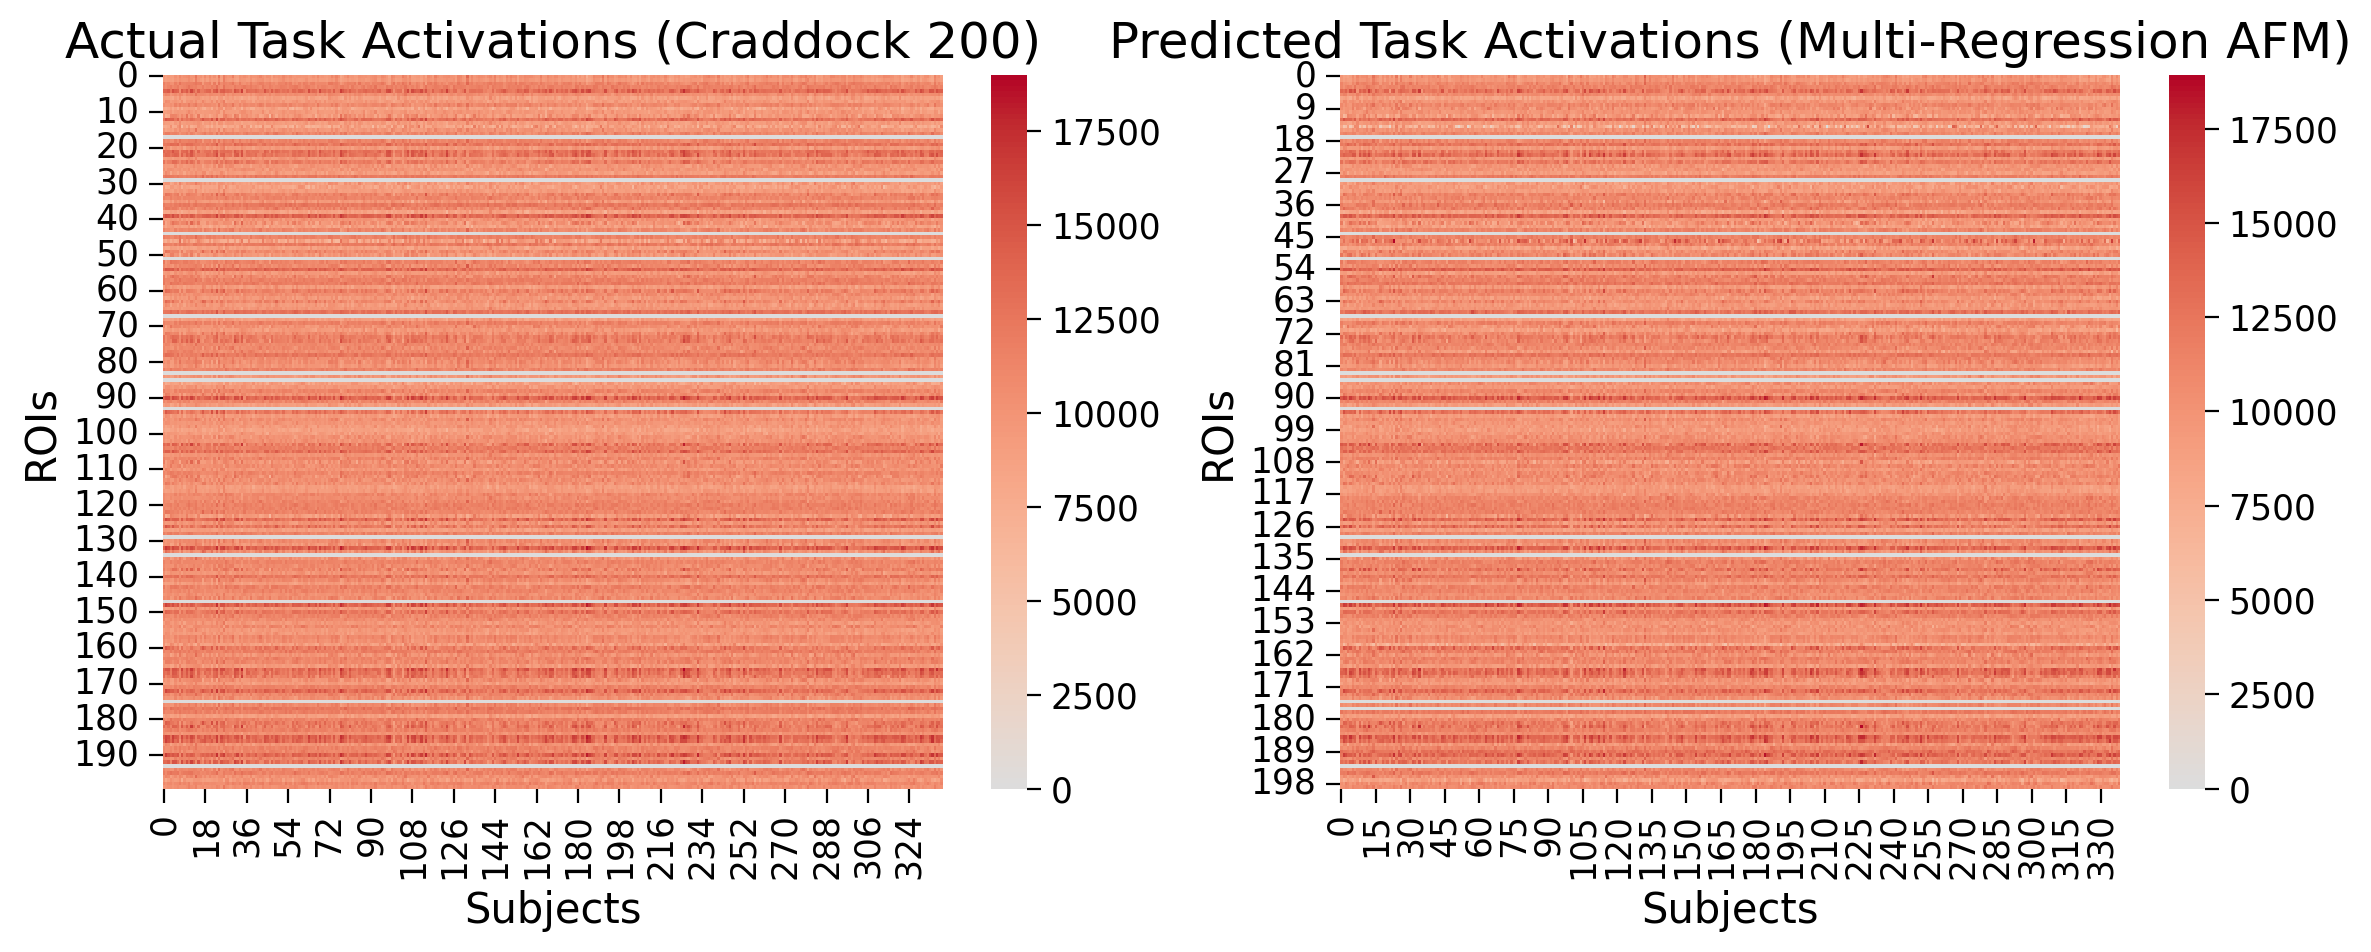

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Heatmap of Actual Activations
plt.subplot(1, 2, 1)
sns.heatmap(task_activations, cmap="coolwarm", center=0)
plt.title("Actual Task Activations (Craddock 200)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

# Heatmap of Predicted Activations (Multi-Regression)
plt.subplot(1, 2, 2)
sns.heatmap(predicted_activations_mreg, cmap="coolwarm", center=0)
plt.title("Predicted Task Activations (Multi-Regression AFM)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


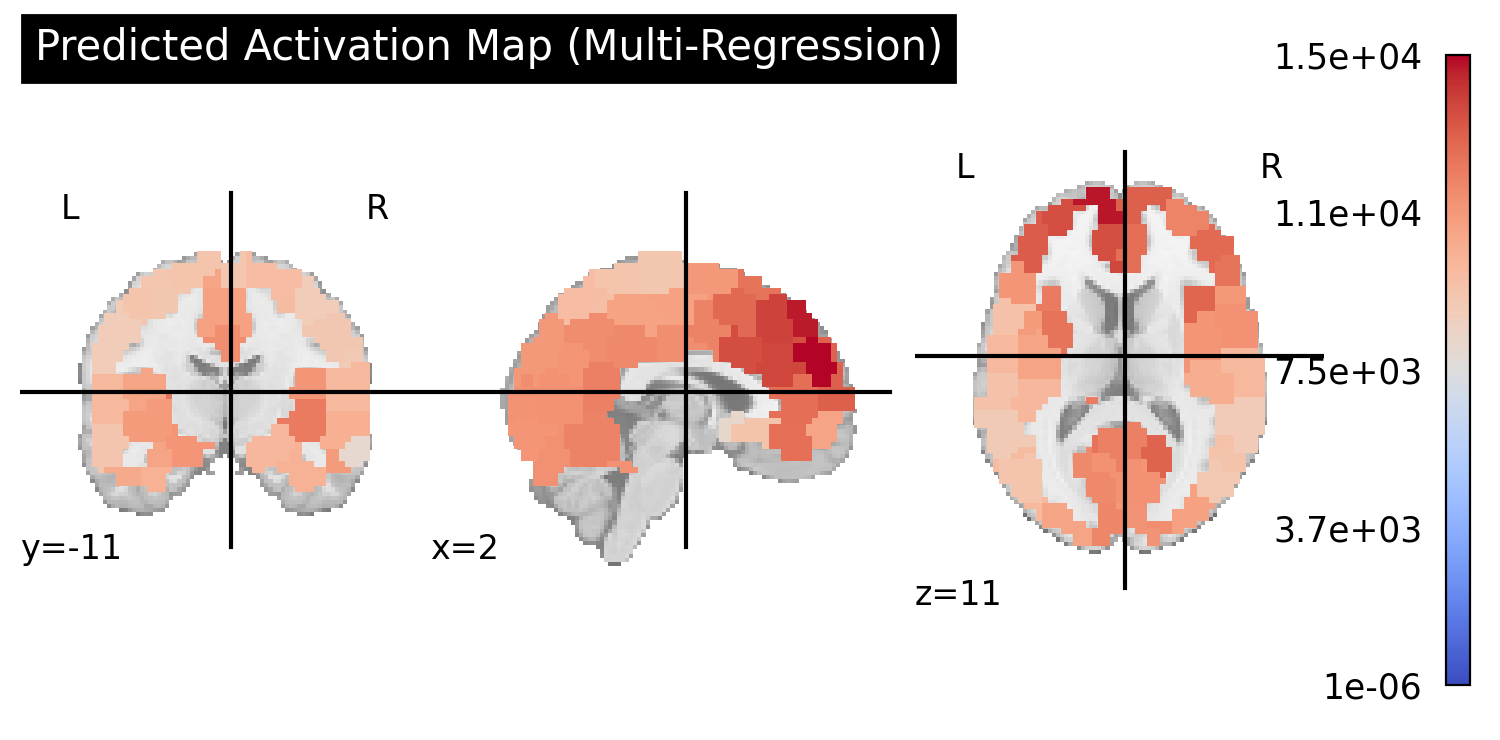

In [ ]:
from nilearn import plotting

# Select a sample subject (e.g., subject 0)
sample_subject_idx = 0
sample_activation_mreg = predicted_activations_mreg[:, sample_subject_idx]

# Load Craddock ROI template for visualization
craddock_atlas = "/content/drive/MyDrive/CC200.nii"
craddock_img = nib.load(craddock_atlas)
craddock_data = craddock_img.get_fdata()

# Map activations to brain volume
brain_map = np.zeros_like(craddock_data)
for roi in range(1, 201):
    brain_map[craddock_data == roi] = sample_activation_mreg[roi - 1]  # Assign predicted activation

# Save and display the brain map
brain_img = nib.Nifti1Image(brain_map, craddock_img.affine)
plotting.plot_stat_map(brain_img, title="Predicted Activation Map (Multi-Regression)", display_mode="ortho", draw_cross=True, cmap="coolwarm")

# ABIDE Dataset

In [ ]:
# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()

    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)

    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_cc200'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset'  # Path to local folder to download files to
desired_diagnosis = 'asd'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050004_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050005_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050006_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050007_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050008_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050009_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050010_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050011_rois_cc200.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
download_data_dir = '/content/drive/MyDrive/preprocessed_dataset'


In [ ]:
import os
import numpy as np
import pandas as pd

# Directory containing the .1D files (replace with your path)
data_dir = '/content/drive/MyDrive/preprocessed_dataset/'

import glob

# Define the path to the subject data files
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200')  # Assuming 1D files for each subject


#Load Abide & Apply HCP Weight

In [ ]:
#log which data is selected

# Parameters
N_ROIS_ABIDE = 200  # Number of ROIs in ABIDE
N_TIMEPOINTS = 200  # Adjust based on your dataset
abide_data_dir = '/content/drive/MyDrive/preprocessed_dataset/interpolated_data'
file_paths = glob.glob(os.path.join(abide_data_dir, '*.npy'))

# Initialize lists to store data and subject IDs
restdata_list = []
selected_subject_ids = []  # Stores extracted subject IDs

for file_path in file_paths:
    filename = os.path.basename(file_path)

    # Extract subject ID (everything before '_rois')
    subject_id_cleaned = filename.split('_rois')[0]  # This will extract "Pitt_0050003"

    try:
        data = np.load(file_path)
        if data.shape != (N_ROIS_ABIDE, N_TIMEPOINTS):
            print(f"Skipping subject {subject_id_cleaned} - unexpected shape {data.shape}")
            continue

        restdata_list.append(data)
        selected_subject_ids.append(subject_id_cleaned)  # Store extracted ID
    except Exception as e:
        print(f"Error loading subject {subject_id_cleaned}: {e}")

# Convert list to numpy array if data exists
if restdata_list:
    restdata_abide = np.stack(restdata_list, axis=2)
    print(f"ABIDE Restdata Loaded Successfully!")
    print(f"ABIDE Restdata Shape: {restdata_abide.shape}")
else:
    print("No valid .npy files were loaded.")

# Summary of selected subjects
if selected_subject_ids:
    print("Summary of Selected Subjects:")
    print(f"Total subjects loaded: {len(selected_subject_ids)}")
    print("Subject IDs:", ", ".join(selected_subject_ids))


Skipping subject restdata.npy - unexpected shape (200, 200, 408)
ABIDE Restdata Loaded Successfully!
ABIDE Restdata Shape: (200, 200, 150)
Summary of Selected Subjects:
Total subjects loaded: 150
Subject IDs: UCLA_1_0051220, UCLA_1_0051225, KKI_0050798, UCLA_1_0051223, Caltech_0051474, Leuven_1_0050696, KKI_0050803, MaxMun_d_0051331, Trinity_0050245, UCLA_2_0051293, Leuven_2_0050743, Trinity_0050237, KKI_0050799, UM_1_0050287, USM_0050525, USM_0050507, UCLA_1_0051208, UCLA_2_0051301, USM_0050500, NYU_0050970, MaxMun_c_0051328, KKI_0050802, MaxMun_a_0051319, UCLA_1_0051236, Pitt_0050055, USM_0050483, Stanford_0051171, USM_0050480, NYU_0051017, CMU_a_0050653, NYU_0051023, UM_1_0050292, SBL_0051576, UCLA_2_0051294, USM_0050494, NYU_0050959, UCLA_1_0051214, NYU_0051000, Stanford_0051178, USM_0050505, NYU_0051026, NYU_0051034, UM_1_0050302, Leuven_1_0050704, Stanford_0051164, NYU_0050960, UM_1_0050285, NYU_0050974, UM_1_0050277, Caltech_0051461, Leuven_1_0050689, Trinity_0050239, Pitt_00500

In [ ]:
%%time
# Prepare for regression (assuming predicted_mean_hcp_compressed is already a task-based matrix)

# Calculate Multiple-Regression FC based on ABIDE resting-state data
numnodes_abide = restdata_abide.shape[0]  # 200 ROIs from ABIDE
numsubjs_abide = restdata_abide.shape[2]  # 150/884 subjects in ABIDE
restFC_mreg_abide = np.zeros((numnodes_abide, numnodes_abide, numsubjs_abide), dtype=np.float64)

for scount in np.arange(numsubjs_abide):
    restFC_mreg_abide[:, :, scount] = actflow.connectivity_estimation.multregconn(restdata_abide[:, :, scount])

CPU times: user 12min 50s, sys: 1.59 s, total: 12min 51s
Wall time: 8min 2s


In [ ]:
restFC_mreg_abide = np.array(restFC_mreg_abide, copy=True)
restFC_mreg_abide.setflags(write=True)

In [ ]:
print(restFC_mreg_abide)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.97961650e+00  3.04190542e+00  4.58633688e+00 ...  5.78075768e+00
    7.73683871e+00  4.24313418e+00]
  [-6.52662574e+00 -6.69867643e+00 -1.14097089e+01 ... -1.30588641e+01
   -2.85015107e+01 -8.40989320e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.47391683e+00
   -1.37503949e+01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.15160516e-01
    3.65891234e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.17992946e-02
   -4.76532335e-01  0.00000000e+00]]

 [[ 3.01615175e-01  2.88314223e-01  2.06847613e-01 ...  1.72987701e-01
    1.29251773e-01  2.26992792e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.27709772e+00  2.30398678e+00  2.59475382e+00 ...  2.25902291e+00
    3.68386990e+00  2.05558030e+00]
  ...
  [ 0.00000000e+00  0.0

In [ ]:
import ActflowToolbox as actflow
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [ ]:
from ActflowToolbox import connectivity_estimation

In [ ]:
print(task_activations.shape)
print(restFC_mreg_abide.shape)

(200, 339)
(200, 200, 150)


In [ ]:
hcp_social_task_mean = np.mean(task_activations, axis=1)

print(hcp_social_task_mean.shape)

(200,)


In [ ]:
# Initialize an array to store predicted activations (200 regions, 150 subjects)
actflowOutput_restFC_abide = np.zeros((200, 150))

# Loop over each ABIDE subject
for subj in range(150):
    # Extract subject-specific FC matrix (200 x 200)
    fcMat_subject = restFC_mreg_abide[:, :, subj]

    # Use the HCP mean activation (200,) as the input
    actflowOutput_restFC_abide[:, subj] = actflow.actflowcomp.actflowcalc(hcp_social_task_mean, fcMat_subject)

In [ ]:
print("Shape:", actflowOutput_restFC_abide.shape)
print("Min:", np.min(actflowOutput_restFC_abide))
print("Max:", np.max(actflowOutput_restFC_abide))
print("Mean:", np.mean(actflowOutput_restFC_abide))
print("NaN values:", np.isnan(actflowOutput_restFC_abide).sum())

Shape: (200, 150)
Min: -201641303.8581099
Max: 535238738.1265561
Mean: 25203.274509208266
NaN values: 0


In [ ]:
# check FC data, Expected: Between -1 and 1
print("FC Min:", np.min(restFC_mreg_abide))
print("FC Max:", np.max(restFC_mreg_abide))
print("Fixed FC Mean:", np.mean(restFC_mreg_abide))

FC Min: -16714.99139004462
FC Max: 15156.208665730046
Fixed FC Mean: 0.011180259400766978


In [ ]:
#Check Task Activation Values, Expected: Between -5 and +5
print("Task Activation Min:", np.min(hcp_social_task_mean))
print("Task Activation Max:", np.max(hcp_social_task_mean))

Task Activation Min: 0.0
Task Activation Max: 14270.637


In [ ]:
print("HCP Task Activation Shape:", hcp_social_task_mean.shape)  # Expected (200,)
print("Resting FC Shape:", restFC_mreg_abide.shape)  # Expected (200, 200, 150)

HCP Task Activation Shape: (200,)
Resting FC Shape: (200, 200, 150)


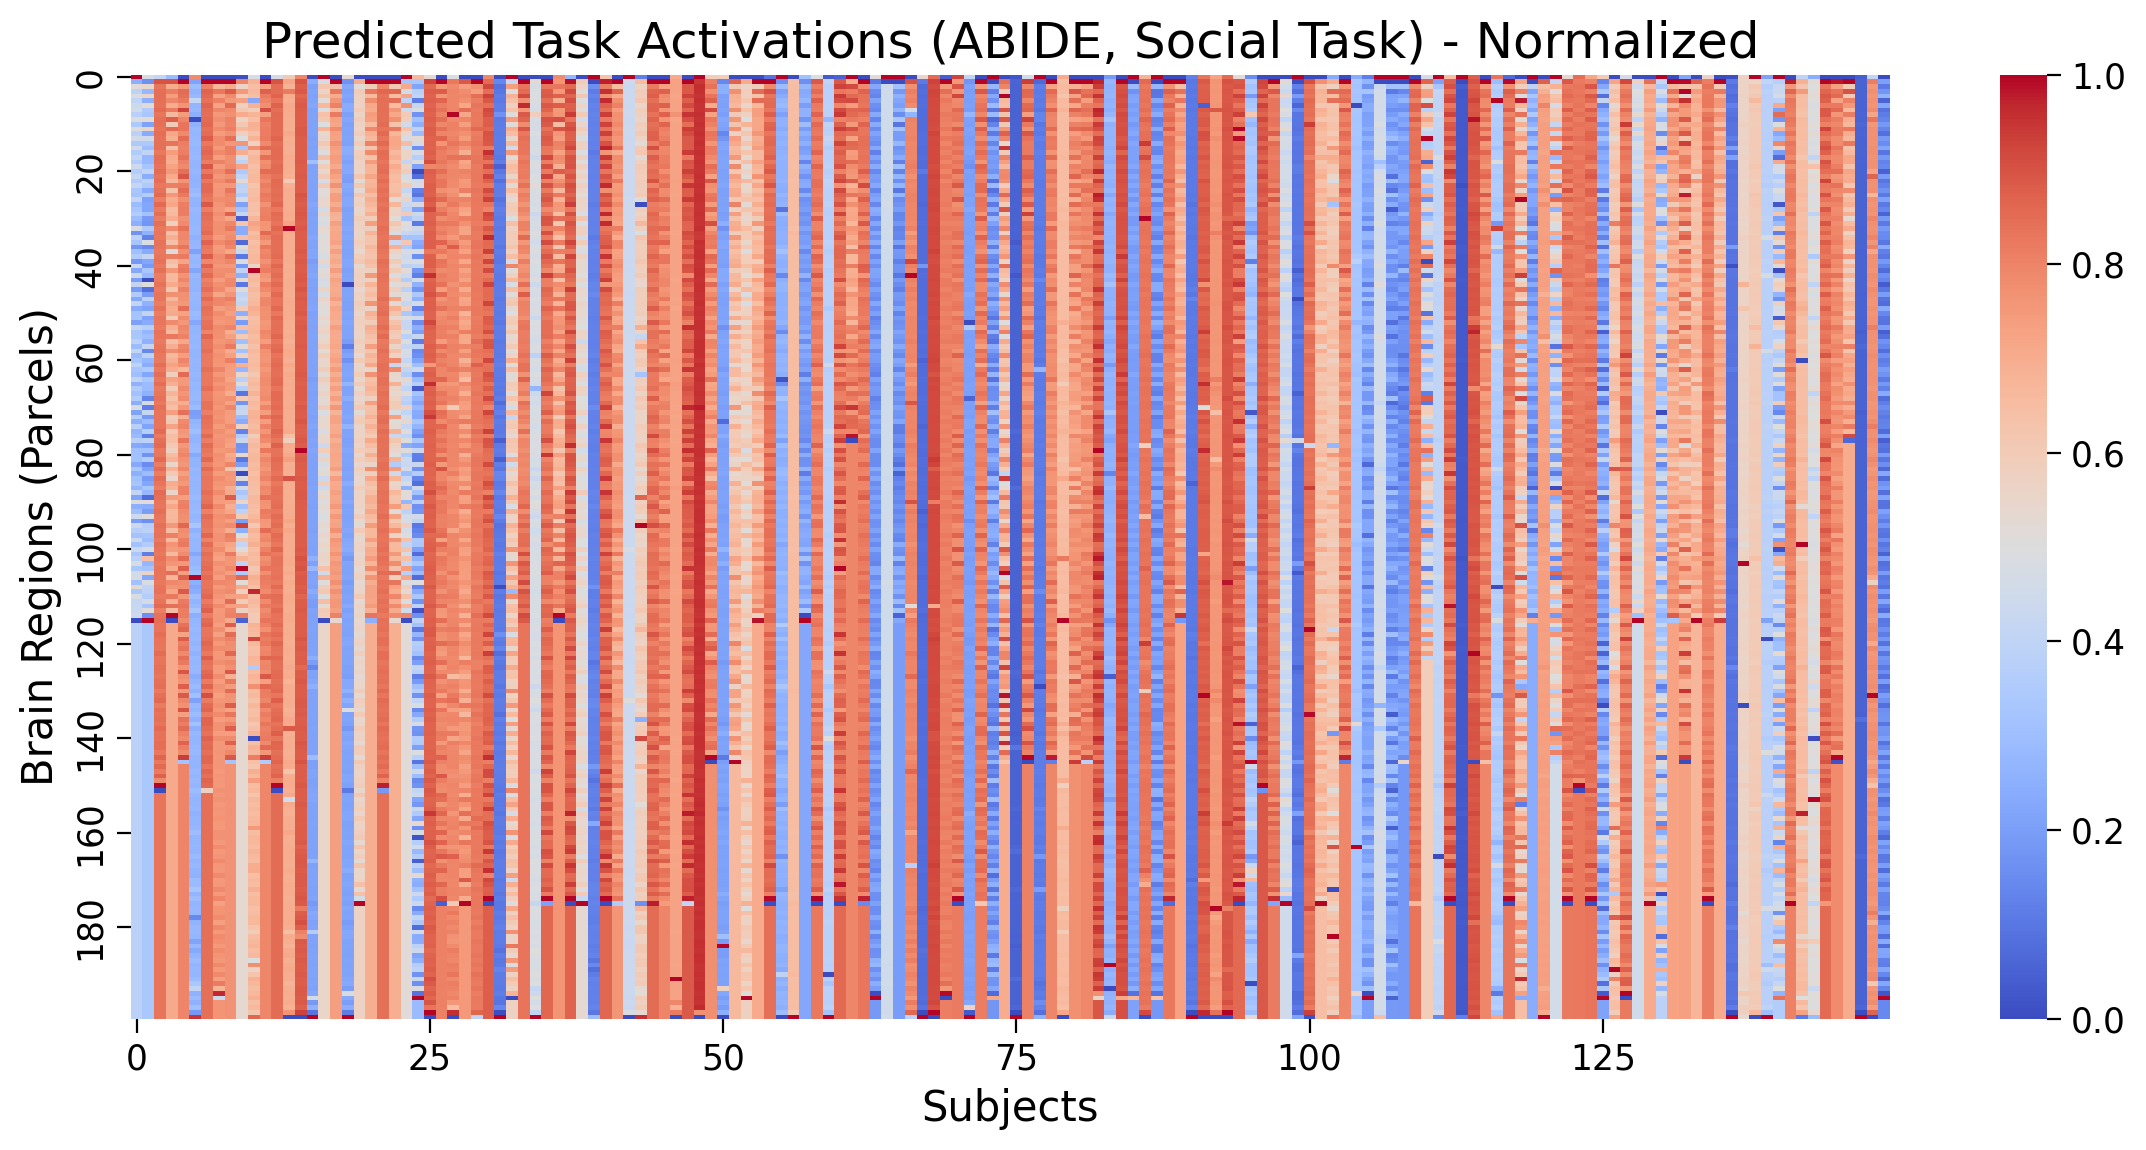

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Normalize data to range [0,1]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(actflowOutput_restFC_abide)

plt.figure(figsize=(12, 6))
sns.heatmap(normalized_data, cmap="coolwarm", xticklabels=25, yticklabels=20)

plt.xlabel("Subjects")
plt.ylabel("Brain Regions (Parcels)")
plt.title("Predicted Task Activations (ABIDE, Social Task) - Normalized")
plt.show()


# ABIDE phenotyical info


In [ ]:
summary_url = "https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"
phenotypic_file = "phenotypic_data.csv"

!wget -O {phenotypic_file} {summary_url}

phenotypic_data = pd.read_csv(phenotypic_file)
phenotypic_data.head()

--2025-03-03 04:16:30--  https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv
Resolving fcp-indi.s3.amazonaws.com (fcp-indi.s3.amazonaws.com)... 16.182.105.81, 16.182.74.201, 3.5.29.99, ...
Connecting to fcp-indi.s3.amazonaws.com (fcp-indi.s3.amazonaws.com)|16.182.105.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 449443 (439K) [application/octet-stream]
Saving to: ‘phenotypic_data.csv’

phenotypic_data.csv 100%[===================>] 438.91K  1.74MB/s    in 0.2s    

2025-03-03 04:16:31 (1.74 MB/s) - ‘phenotypic_data.csv’ saved [449443/449443]



,Unnamed: 0.1,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


In [ ]:
# match the ADI-R score with selected data

# Ensure subject ID column in the CSV file is treated as a string
phenotypic_data['FILE_ID'] = phenotypic_data['FILE_ID'].astype(str)

# Create DataFrame from selected_subject_ids
selected_df = pd.DataFrame({'FILE_ID': selected_subject_ids})

# Merge to get ADI_R_VERBAL_TOTAL_BV scores
matched_data = selected_df.merge(phenotypic_data[['FILE_ID', 'ADI_R_VERBAL_TOTAL_BV']], on='FILE_ID', how='left')

# Screen subjects with missing ADI-R scores at the beginning
matched_data = matched_data.dropna(subset=['ADI_R_VERBAL_TOTAL_BV'])  # Remove subjects without ADI-R score

# Extract final subject list
final_subject_ids = matched_data['FILE_ID'].tolist()

# Extract ADI-R scores as a NumPy array
adi_r_scores = matched_data['ADI_R_VERBAL_TOTAL_BV'].values

print(adi_r_scores.shape)


(109,)


In [ ]:
# Identify indices of selected subjects in the original list
subject_indices = [selected_subject_ids.index(subj) for subj in final_subject_ids]

# Extract brain activity only for subjects with valid ADI-R scores
filtered_brain_activity = actflowOutput_restFC_abide[:, subject_indices]  # Shape: (200, valid_subject_count)

print(filtered_brain_activity.shape)


(200, 109)


In [ ]:
from scipy.stats import pearsonr

# Initialize array to store correlation coefficients
correlation_results = np.zeros(200)  # One correlation per region

# Compute Pearson correlation for each region
for region in range(200):
    brain_region_activity = filtered_brain_activity[region, :]
    r, _ = pearsonr(brain_region_activity, adi_r_scores)  # Compute correlation
    correlation_results[region] = r  # Store result

# Convert to DataFrame for visualization
correlation_df = pd.DataFrame({
    'Region': np.arange(1, 201),  # Regions indexed from 1 to 200
    'Correlation': correlation_results
})

print(correlation_df.head())

   Region  Correlation
0       1    -0.018439
1       2     0.153510
2       3    -0.230800
3       4     0.057917
4       5    -0.101012


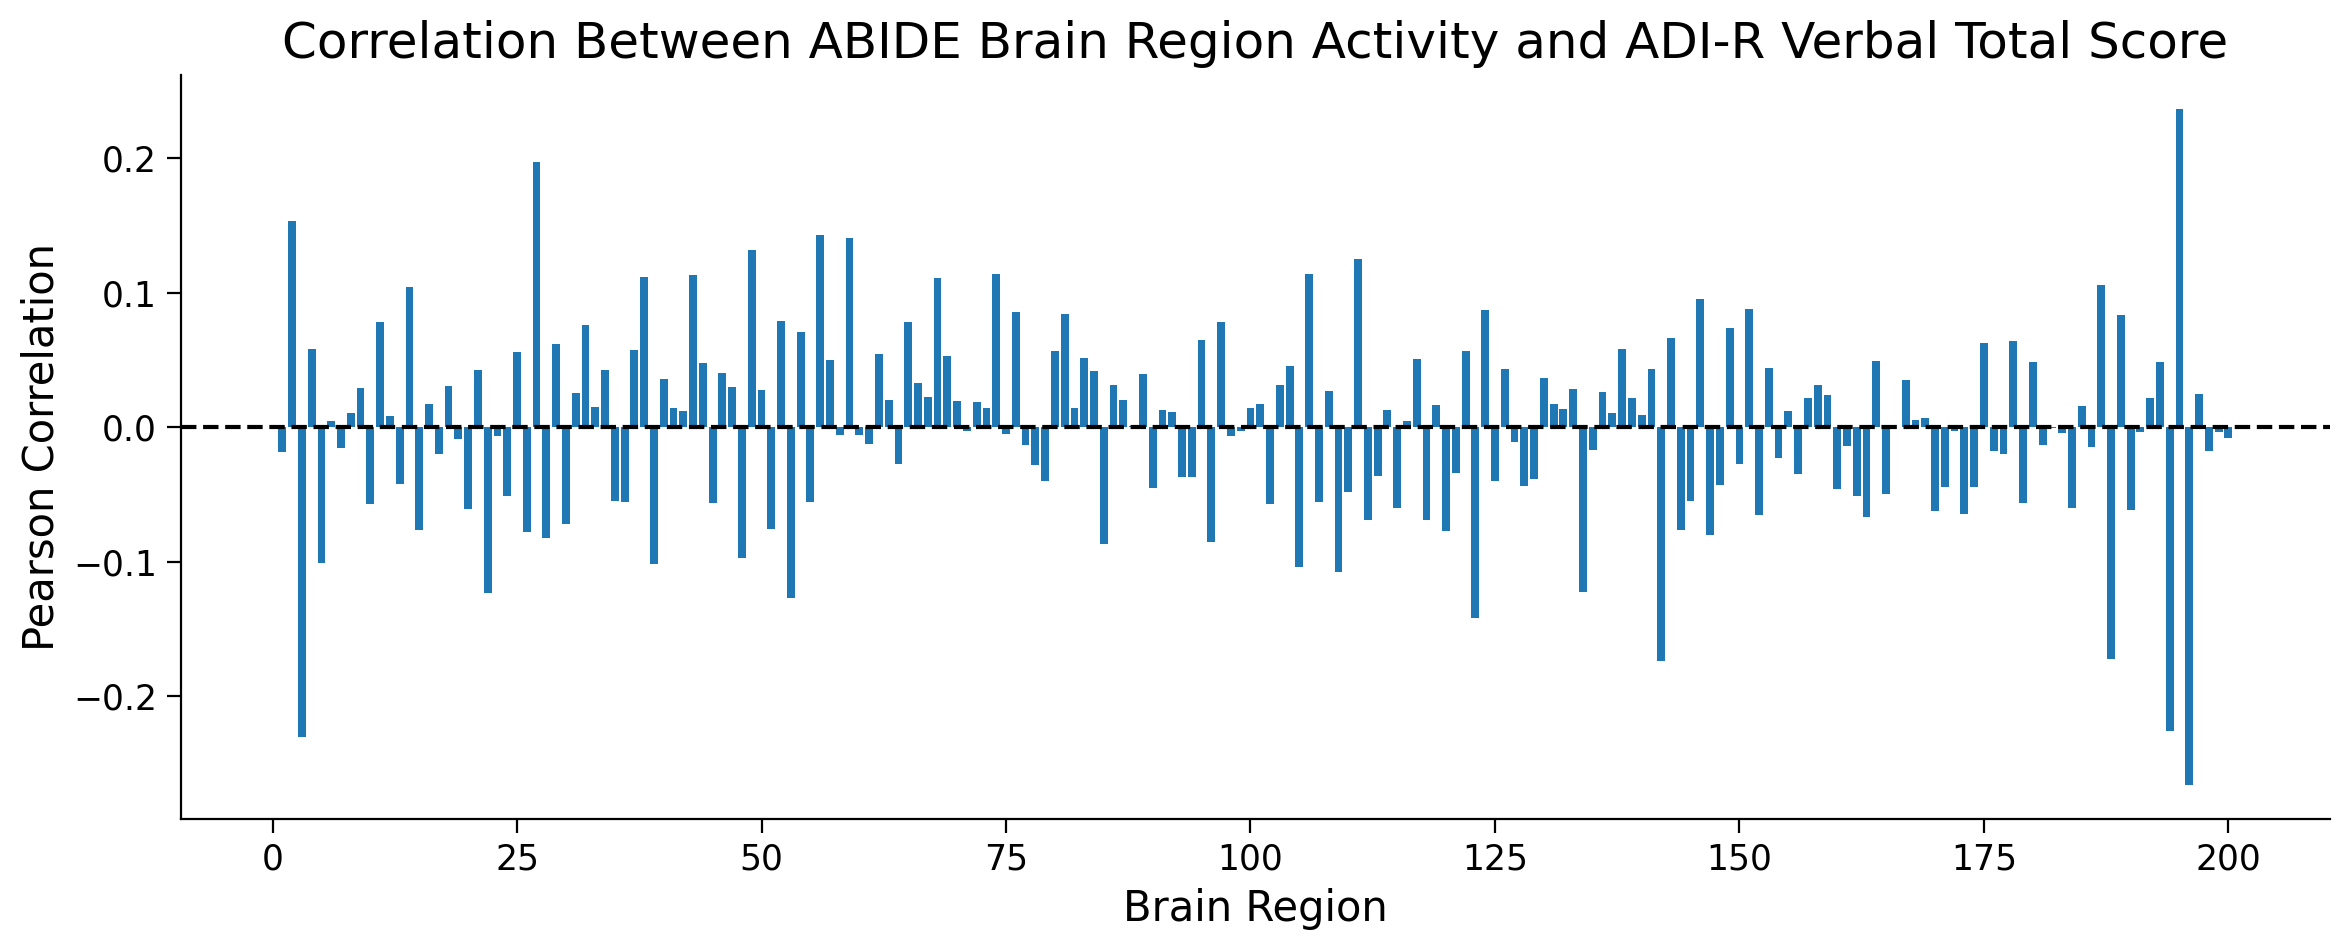

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(correlation_df['Region'], correlation_df['Correlation'])
plt.axhline(0, color='black', linestyle='--')  # Reference line at 0
plt.xlabel("Brain Region")
plt.ylabel("Pearson Correlation")
plt.title("Correlation Between ABIDE Brain Region Activity and ADI-R Verbal Total Score")
plt.show()


In [ ]:
correlation_df_sorted = correlation_df.sort_values(by="Correlation", key=abs, ascending=False)
print(correlation_df_sorted.head(10))  # View the top 10 most correlated regions

     Region  Correlation
195     196    -0.266444
194     195     0.236874
2         3    -0.230800
193     194    -0.225763
26       27     0.197312
141     142    -0.174002
187     188    -0.172260
1         2     0.153510
55       56     0.143061
122     123    -0.142031


In [ ]:
from scipy.stats import pearsonr

p_values = []
for region in range(200):
    brain_region_activity = filtered_brain_activity[region, :]
    _, p = pearsonr(brain_region_activity, adi_r_scores)  # Compute p-value
    p_values.append(p)

correlation_df["p-value"] = p_values

# Display significant correlations (p < 0.05)
significant_regions = correlation_df[correlation_df["p-value"] < 0.05]
print(significant_regions)


     Region  Correlation   p-value
2         3    -0.230800  0.015755
26       27     0.197312  0.039733
193     194    -0.225763  0.018254
194     195     0.236874  0.013141
195     196    -0.266444  0.005102


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


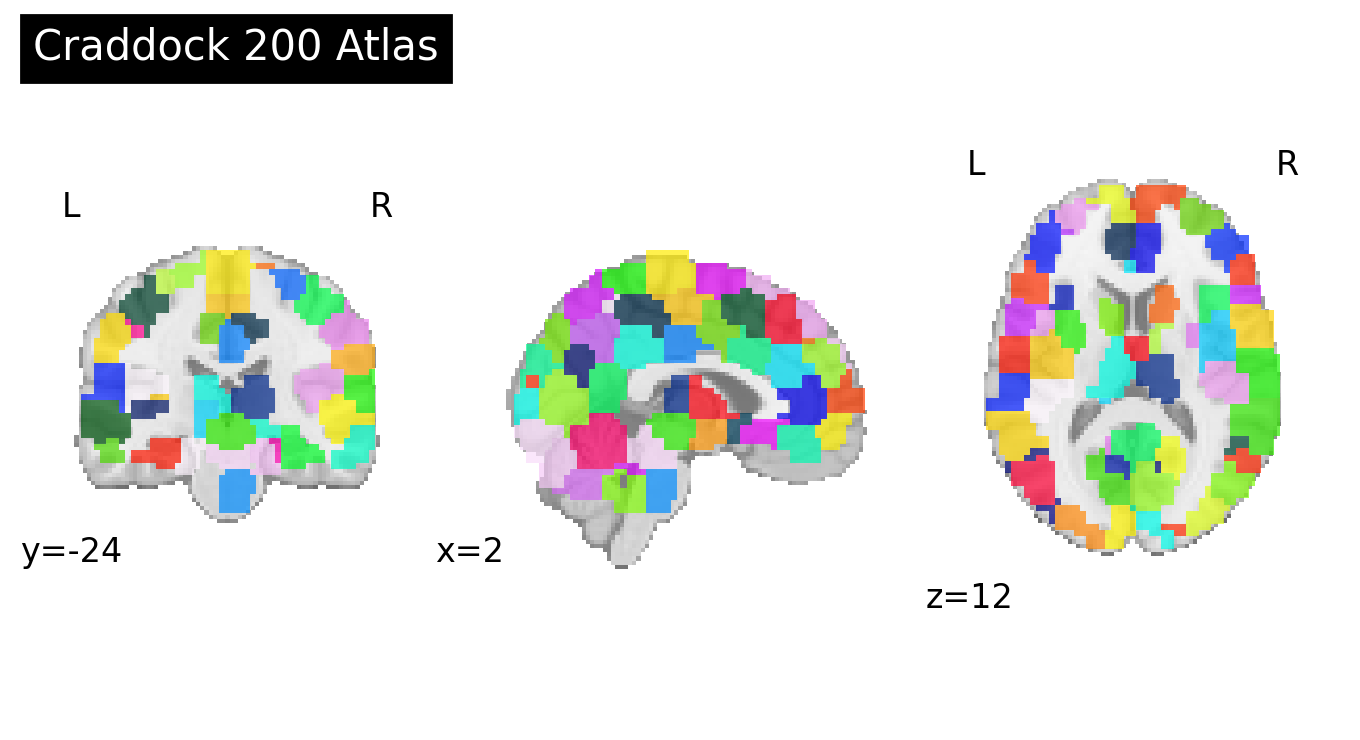

In [ ]:
from nilearn import image, plotting
import numpy as np

# Path to the downloaded Craddock 2012 Atlas (200 ROI version)
atlas_path = "/content/drive/MyDrive/cc200_roi_atlas.nii"  # Update this path

# Load the atlas as a Nifti image
atlas_img = image.load_img(atlas_path)

# Display the Atlas (optional, to check if it's correctly loaded)
plotting.plot_roi(atlas_img, title="Craddock 200 Atlas", draw_cross=False)
plotting.show()


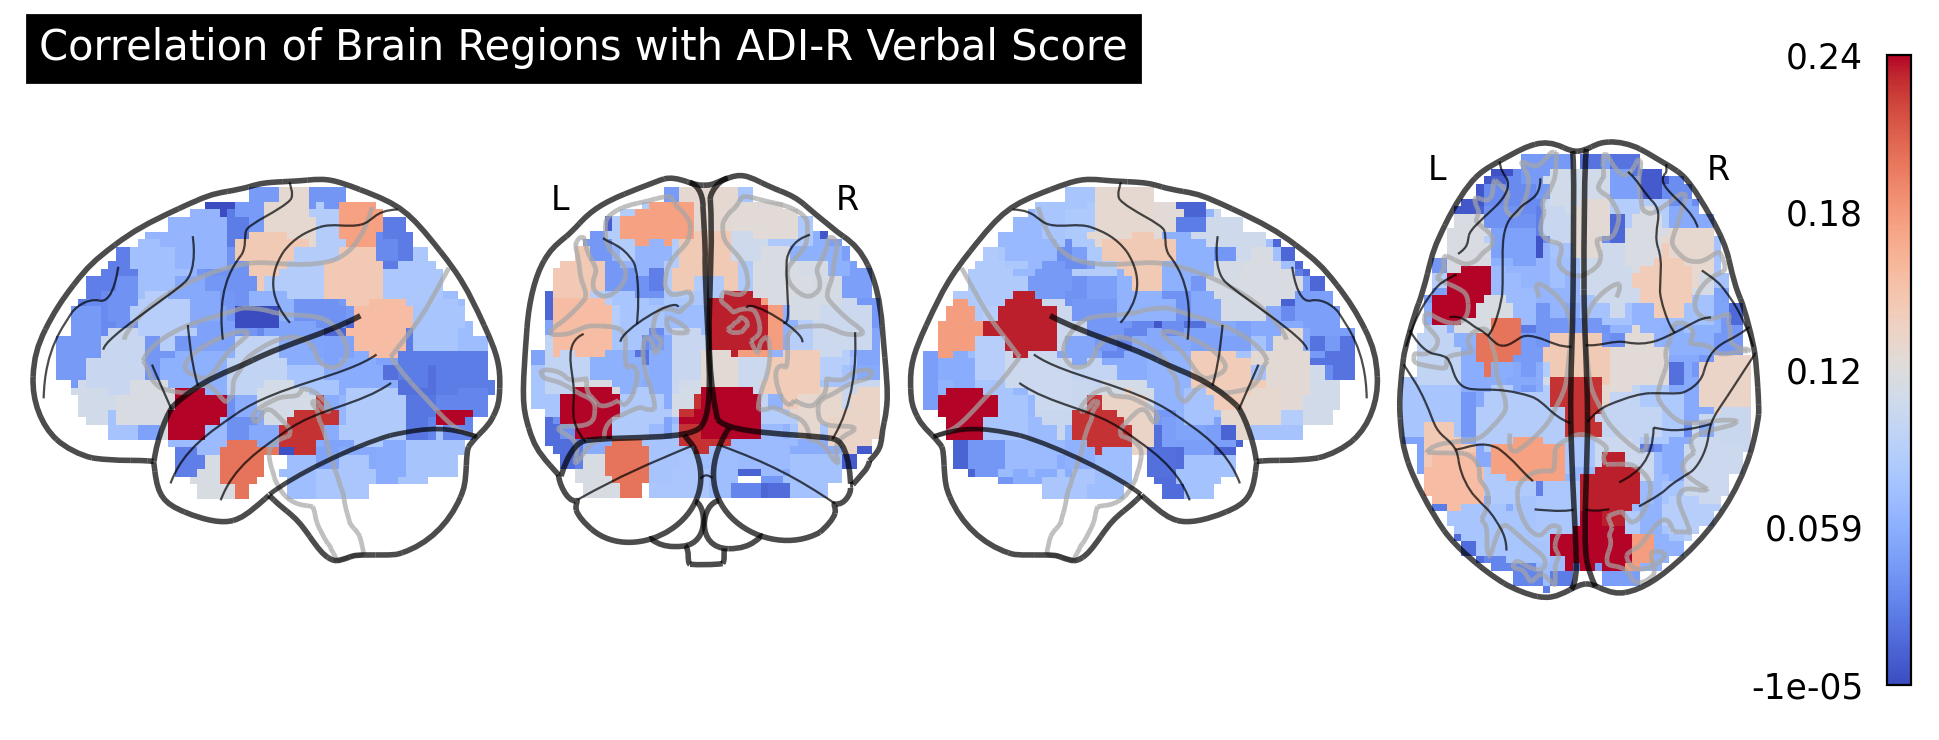

In [ ]:
import nibabel as nib

# Load atlas data as a numpy array
atlas_data = atlas_img.get_fdata()

# Create an empty image to store correlation values (same shape as atlas)
correlation_map = np.zeros_like(atlas_data)

# Load correlation values (ensure they are correctly ordered)
correlation_values = correlation_df["Correlation"].values  # Shape (200,)

# Assign correlation values to corresponding ROIs
for roi_index in range(200):  # ROIs are indexed from 1 to 200
    correlation_map[atlas_data == (roi_index + 1)] = correlation_values[roi_index]

# Convert modified array back to a Nifti image
correlation_img = nib.Nifti1Image(correlation_map, affine=atlas_img.affine)

# Plot the correlation results using a glass brain view
plotting.plot_glass_brain(
    correlation_img,
    display_mode='lyrz',  # Show all orientations (Left, Right, Axial, Sagittal)
    title="Correlation of Brain Regions with ADI-R Verbal Score",
    colorbar=True,
    cmap="coolwarm"
)

plotting.show()


# Comparison with HCP task data

In [ ]:
# compare average HCP task dat and average predictive ABIDE task data

# Compute mean predicted ABIDE activation
abide_task_mean_avg = np.mean(actflowOutput_restFC_abide, axis=1)

# Apply z-score normalization to bring values to a standard range
from scipy.stats import zscore
hcp_social_task_mean_z = zscore(hcp_social_task_mean)
abide_task_mean_avg_z = zscore(abide_task_mean_avg)


# Clip extreme values in ABIDE
clip_value = np.percentile(abide_task_mean_avg_z, 99)  # Get 99th percentile to remove extreme outliers
abide_task_mean_avg_z = np.clip(abide_task_mean_avg_z, -clip_value, clip_value)

print("Clipped ABIDE Task Activation - Min:", np.min(abide_task_mean_avg_z), "Max:", np.max(abide_task_mean_avg_z))


Clipped ABIDE Task Activation - Min: -1.555967932619028 Max: 1.555967932619028


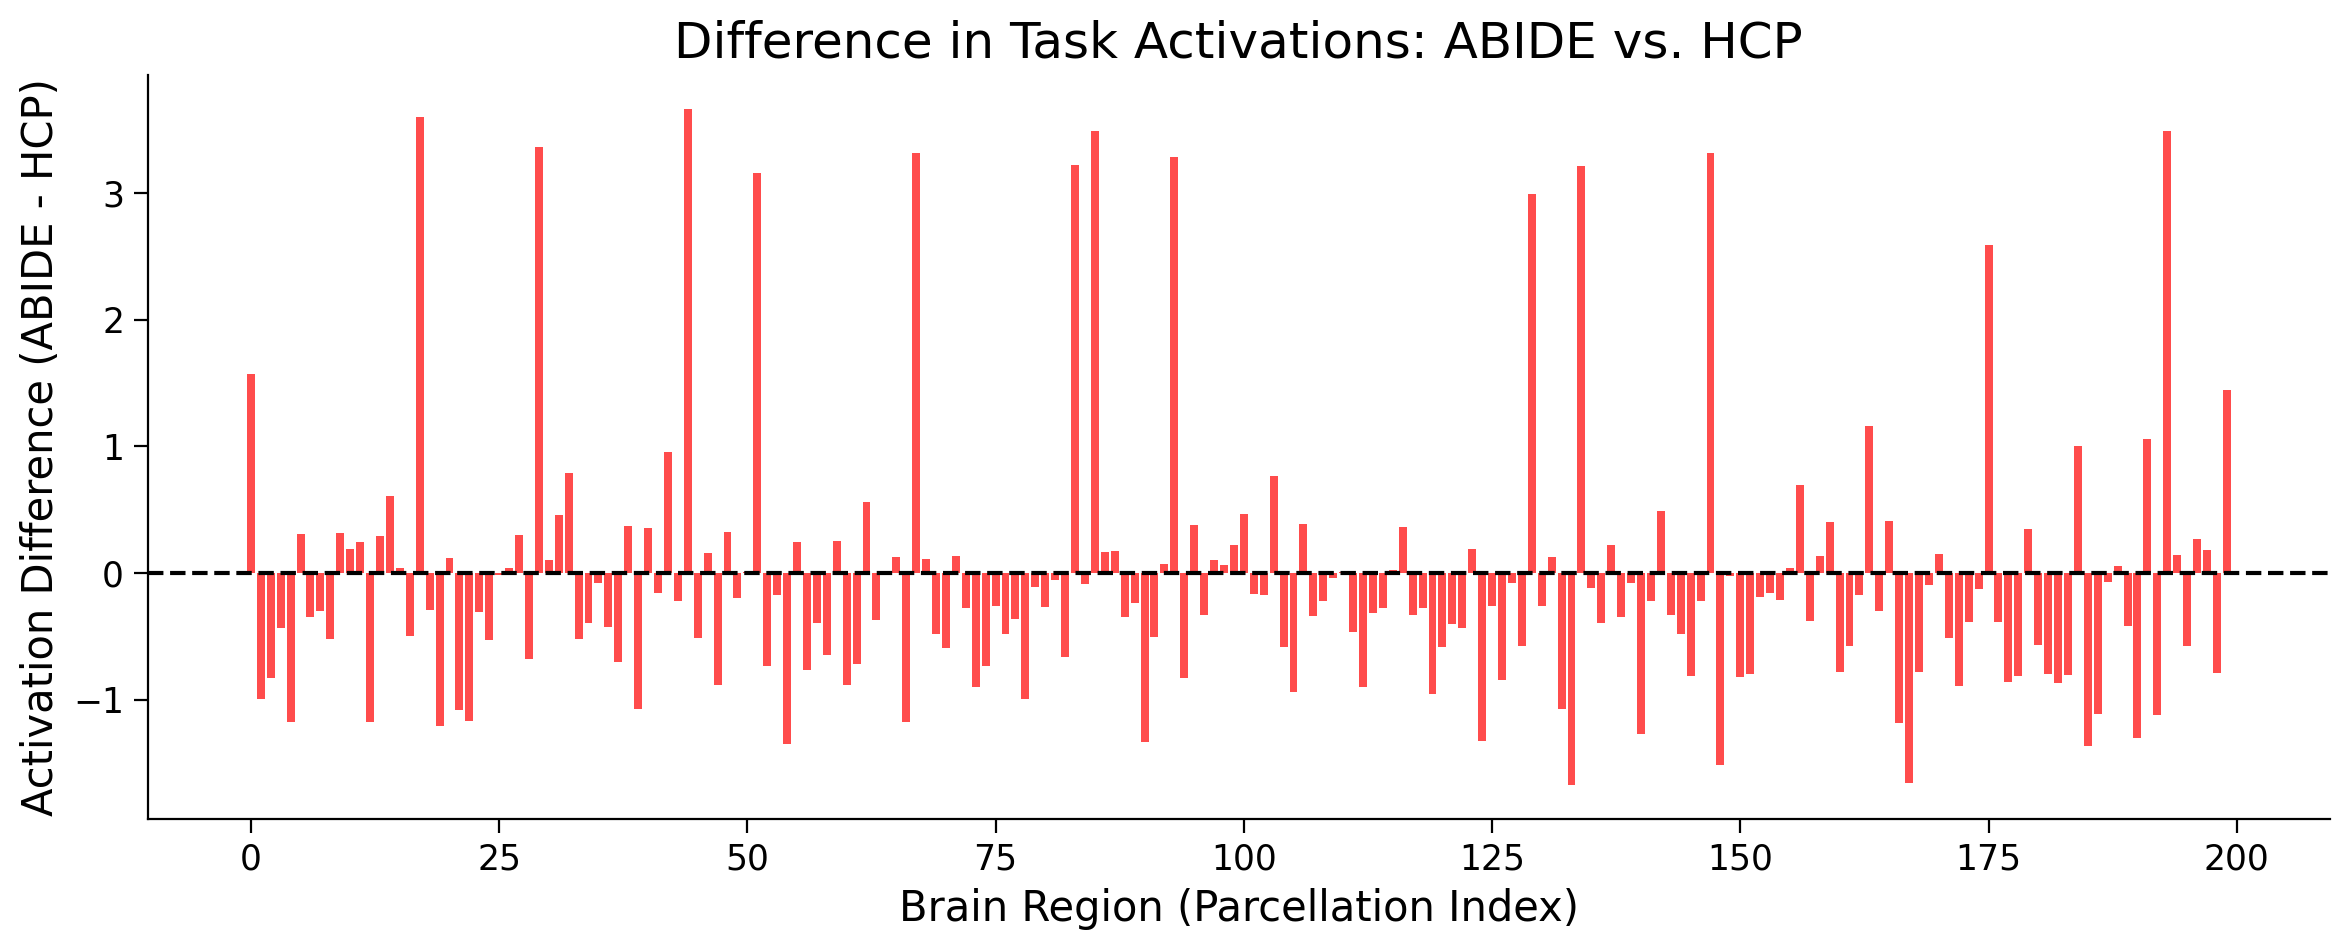

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(range(200), abide_task_mean_avg_z - hcp_social_task_mean_z, color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')  # Baseline for reference
plt.xlabel("Brain Region (Parcellation Index)")
plt.ylabel("Activation Difference (ABIDE - HCP)")
plt.title("Difference in Task Activations: ABIDE vs. HCP")
plt.show()


In [ ]:
from scipy.stats import ttest_rel

# Perform a paired t-test for each brain region
t_stat, p_values = ttest_rel(hcp_social_task_mean_z, abide_task_mean_avg_z)

# Find significant regions (p < 0.05)
significant_regions = np.where(p_values < 0.05)[0]

print(f"Number of significantly different brain regions: {len(significant_regions)}")


Number of significantly different brain regions: 0


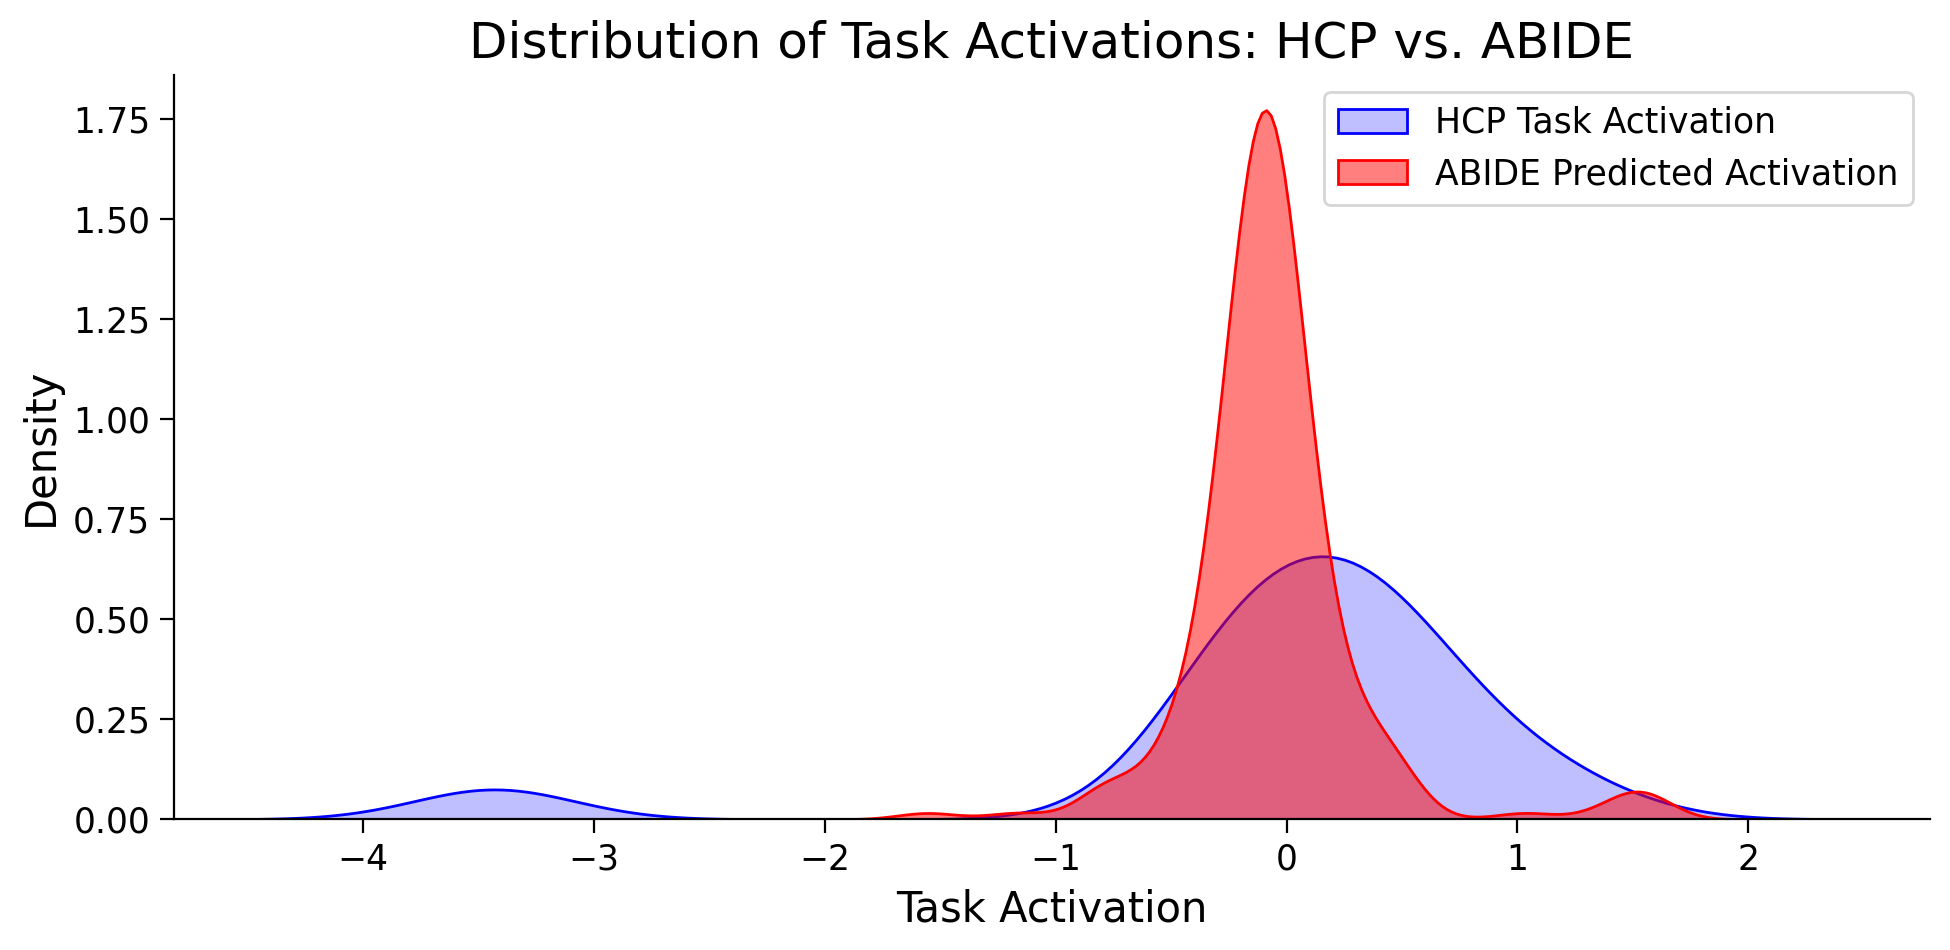

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(hcp_social_task_mean_z, label="HCP Task Activation", color='blue', fill=True)
sns.kdeplot(abide_task_mean_avg_z, label="ABIDE Predicted Activation", color='red', fill=True, alpha=0.5)
plt.xlabel("Task Activation")
plt.ylabel("Density")
plt.title("Distribution of Task Activations: HCP vs. ABIDE")
plt.legend()
plt.show()


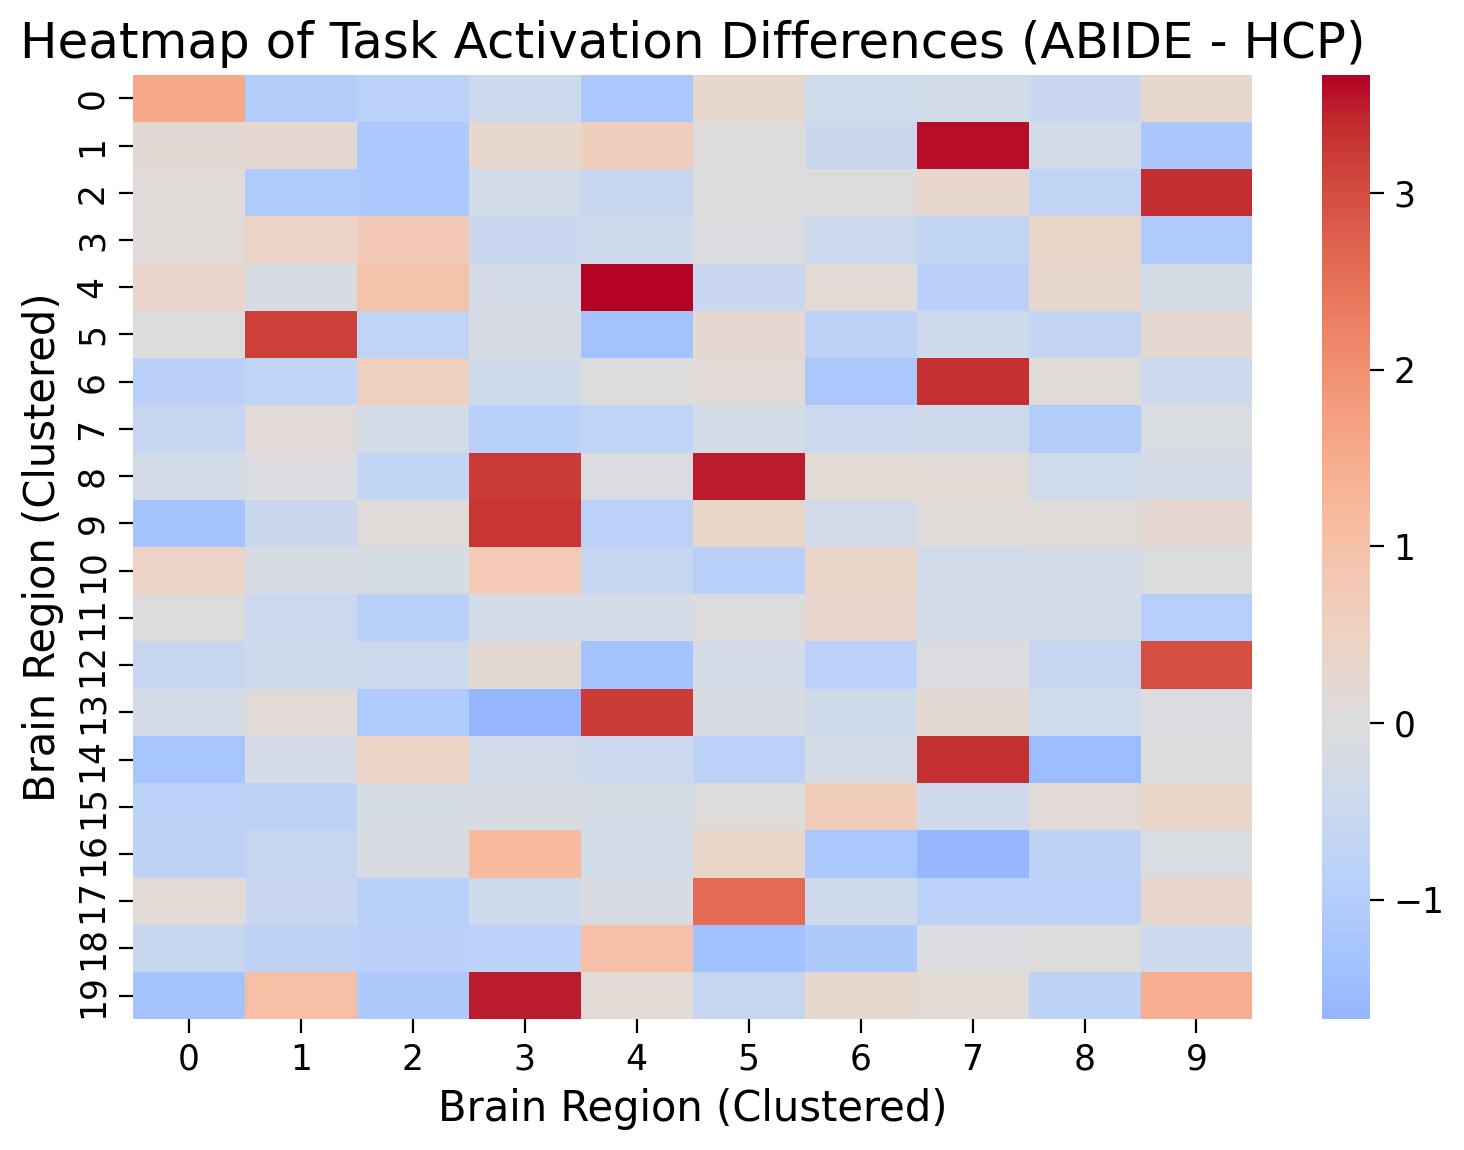

In [ ]:
sns.heatmap((abide_task_mean_avg_z - hcp_social_task_mean_z).reshape(20, 10), cmap="coolwarm", center=0)
plt.title("Heatmap of Task Activation Differences (ABIDE - HCP)")
plt.xlabel("Brain Region (Clustered)")
plt.ylabel("Brain Region (Clustered)")
plt.show()


In [ ]:
from nilearn import plotting
from nilearn import datasets, image
from nilearn.input_data import NiftiLabelsMasker

activation_difference = abide_task_mean_avg_z - hcp_social_task_mean_z

# Load CC200
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)  # Change if using a different atlas
atlas_img = image.load_img(atlas_path)


# Extract unique region labels (ignore background = 0)
atlas_labels = np.unique(atlas_img.get_fdata())
atlas_labels = atlas_labels[atlas_labels > 0]  # Remove zero (background)

print(f"Number of unique atlas regions: {len(atlas_labels)}")  # Should match your parcellation (200)



[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

Number of unique atlas regions: 200


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


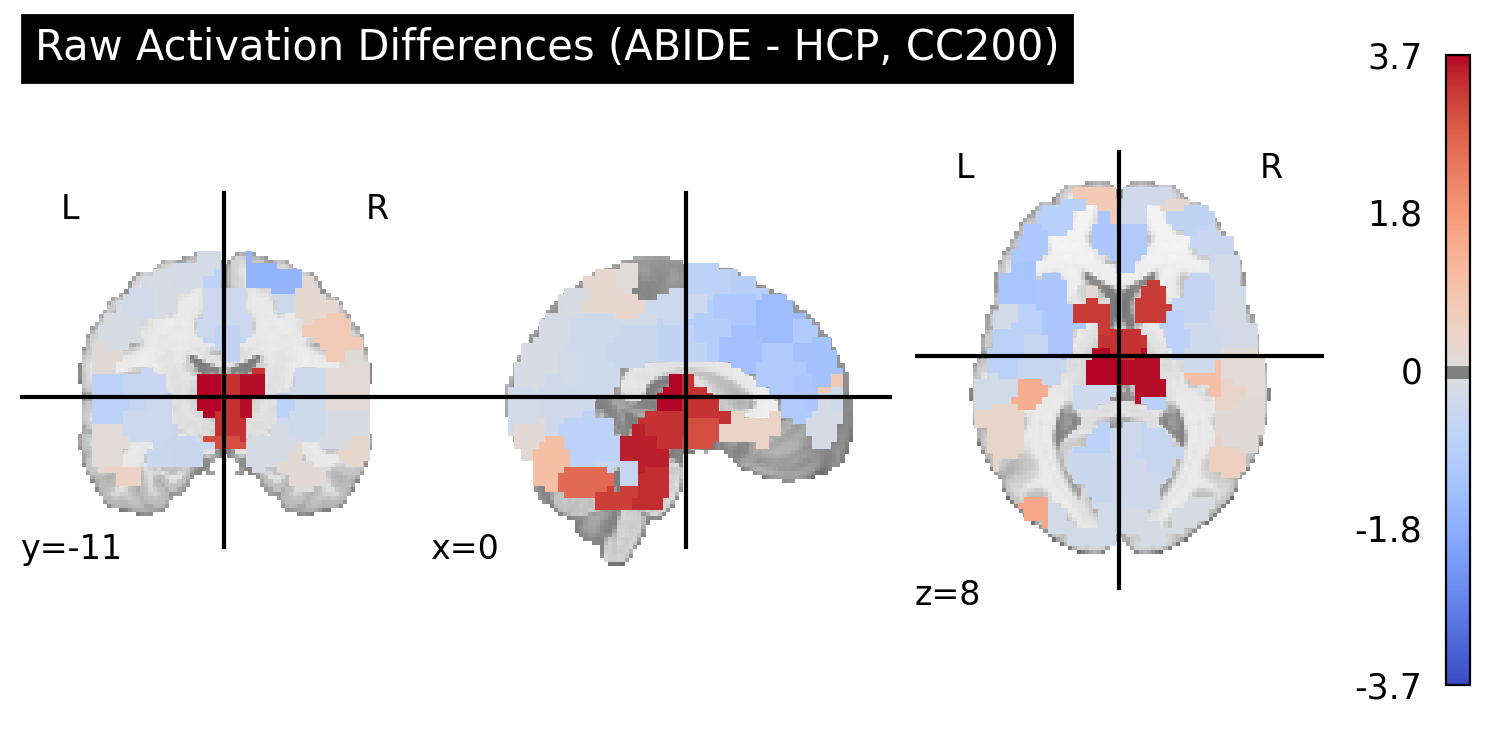

In [ ]:
# Initialize an empty 3D stat map (same shape as atlas)
stat_map = np.zeros(atlas_img.shape)

# Assign activation values to their corresponding regions
for i, label in enumerate(atlas_labels):
    stat_map[atlas_img.get_fdata() == label] = activation_difference[i]  # Correct indexing

# Convert stat_map to a new NIfTI image
stat_img = image.new_img_like(atlas_img, stat_map)

# Plot the differences on a brain map
plotting.plot_stat_map(
    stat_img,
    title="Raw Activation Differences (ABIDE - HCP, CC200)",
    cmap="coolwarm",
    threshold=0.1,  # Adjust if needed
    colorbar=True
)
plotting.show()


In [ ]:
# label the different regions


# Load the CC200 labels file (update path as needed)
labels_path = "/content/drive/MyDrive/CC200_ROI_labels.csv"  # Update with actual file path
region_labels = pd.read_csv(labels_path)

# Number of top different regions to display
N = 10

# Get indices of the top N largest activation differences
top_regions_idx = np.argsort(np.abs(activation_difference))[-N:]

# Print the matched brain regions
print("\nTop", N, "Regions with Largest Activation Differences (ABIDE - HCP):")
for i in top_regions_idx:
    print(f"Region: {region_labels.iloc[i, 1]} | Index: {i} | Difference: {activation_difference[i]}")



Top 10 Regions with Largest Activation Differences (ABIDE - HCP):
Region: 143 | Index: 134 | Difference: 3.2184705431996417
Region: 83 | Index: 83 | Difference: 3.2194326343428696
Region: 87 | Index: 93 | Difference: 3.287817970154151
Region: 172 | Index: 147 | Difference: 3.319641106216465
Region: 216 | Index: 67 | Difference: 3.3197108350771294
Region: 194 | Index: 29 | Difference: 3.365794402769609
Region: 199 | Index: 193 | Difference: 3.488231277325076
Region: 185 | Index: 85 | Difference: 3.4917683481921493
Region: 212 | Index: 17 | Difference: 3.5986299299010263
Region: 202 | Index: 44 | Difference: 3.6695048564277513


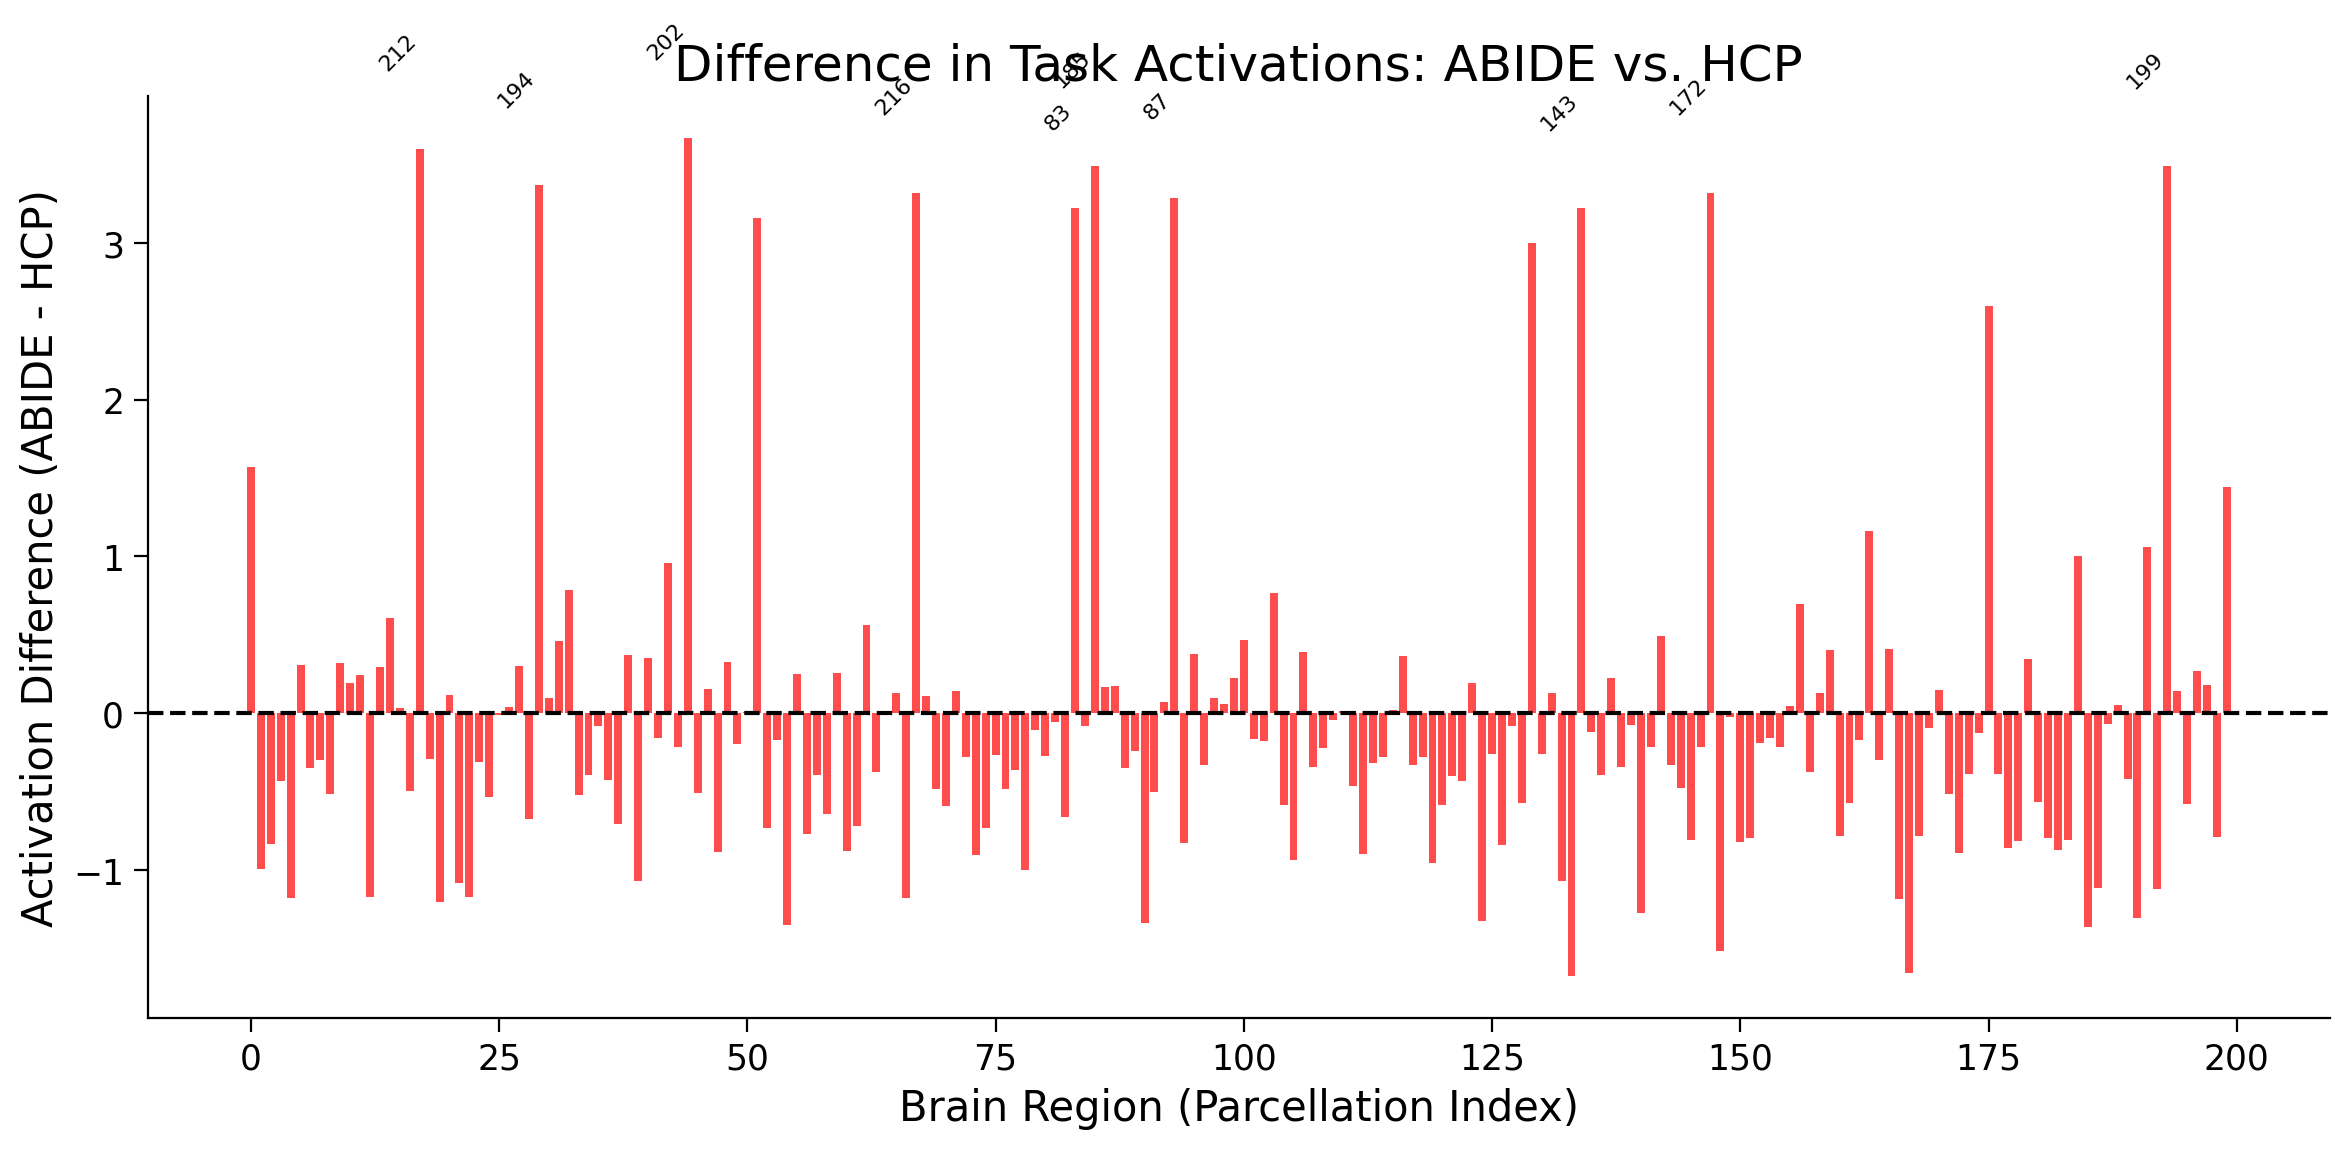

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(range(200), activation_difference, color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')  # Baseline

# Add labels to the top different regions
for i in top_regions_idx:
    plt.text(i, activation_difference[i] + 0.5, region_labels.iloc[i, 1],
             rotation=45, ha='right', fontsize=8, color='black')

plt.xlabel("Brain Region (Parcellation Index)")
plt.ylabel("Activation Difference (ABIDE - HCP)")
plt.title("Difference in Task Activations: ABIDE vs. HCP")
plt.show()


In [ ]:
# map the average task activations from HCP and ABIDE onto the CC200 atlas

from nilearn.input_data import NiftiLabelsMasker

# Create a masker to extract brain regions from the atlas
masker = NiftiLabelsMasker(atlas_img, standardize=True)
atlas_labels = masker.fit_transform(atlas_img)

# Initialize empty 3D brain maps
hcp_stat_map = np.zeros(atlas_img.shape)
abide_stat_map = np.zeros(atlas_img.shape)

# Assign activation values to atlas regions
unique_labels = np.unique(atlas_img.get_fdata())
unique_labels = unique_labels[unique_labels > 0]  # Remove background (label 0)

for i, label in enumerate(unique_labels):
    hcp_stat_map[atlas_img.get_fdata() == label] = hcp_social_task_mean_z[i]
    abide_stat_map[atlas_img.get_fdata() == label] = abide_task_mean_avg_z[i]


/usr/local/lib/python3.11/dist-packages/nilearn/signal.py:77: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn(


In [ ]:
vmax = max(np.max(hcp_social_task_mean_z), np.max(abide_task_mean_avg_z))  # Maximum activation across both
vmin = -vmax  # Keep it symmetric

print("New Color Scale:", vmin, "to", vmax)


New Color Scale: -1.555967932619028 to 1.555967932619028


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


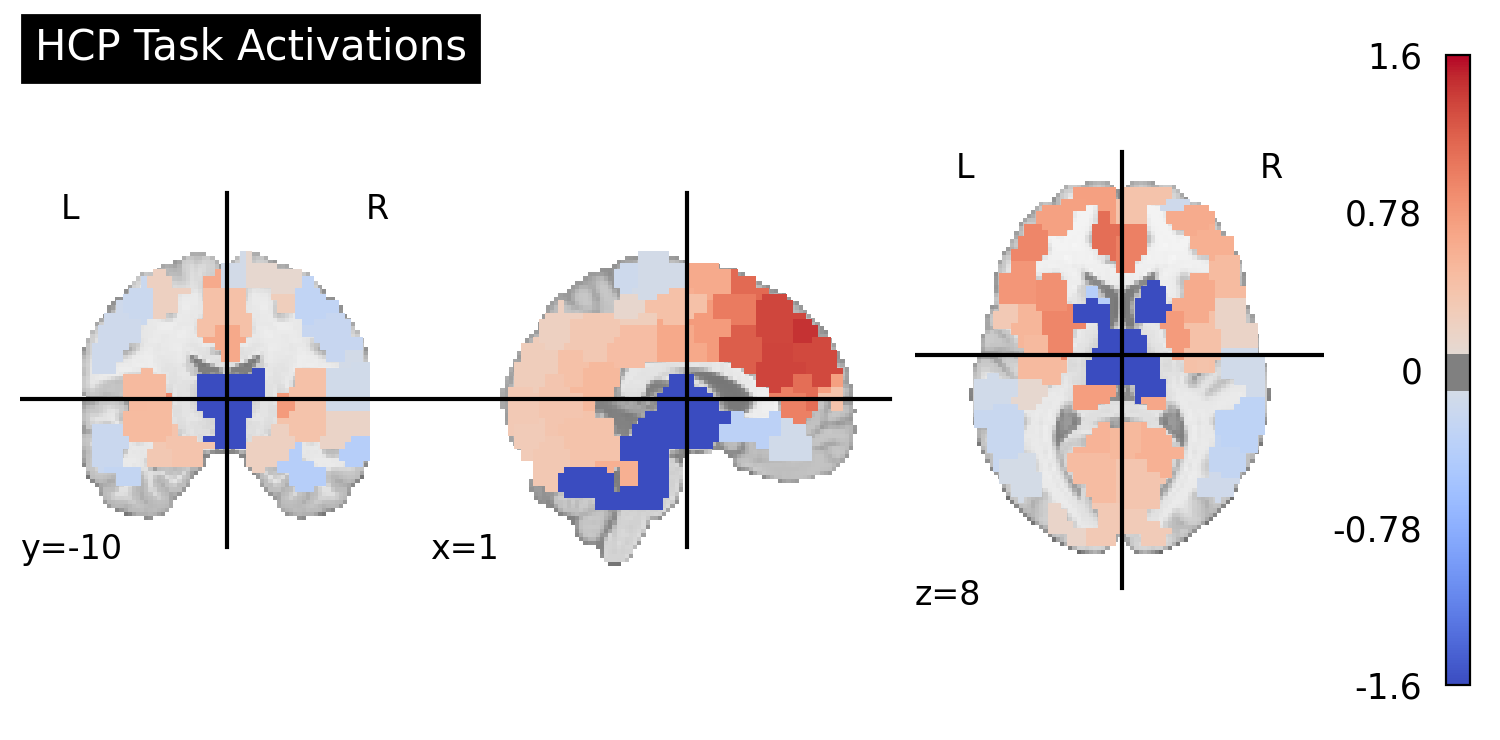

In [ ]:
# HCP

# Convert stat map to a NifTI image
hcp_stat_img = image.new_img_like(atlas_img, hcp_stat_map)

# Display the HCP task activation
plotting.plot_stat_map(
    hcp_stat_img,
    title="HCP Task Activations",
    cmap="coolwarm",
    threshold=0.1,  # Adjust threshold if needed
    vmax=vmax, vmin=vmin,
    colorbar=True
)
plotting.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


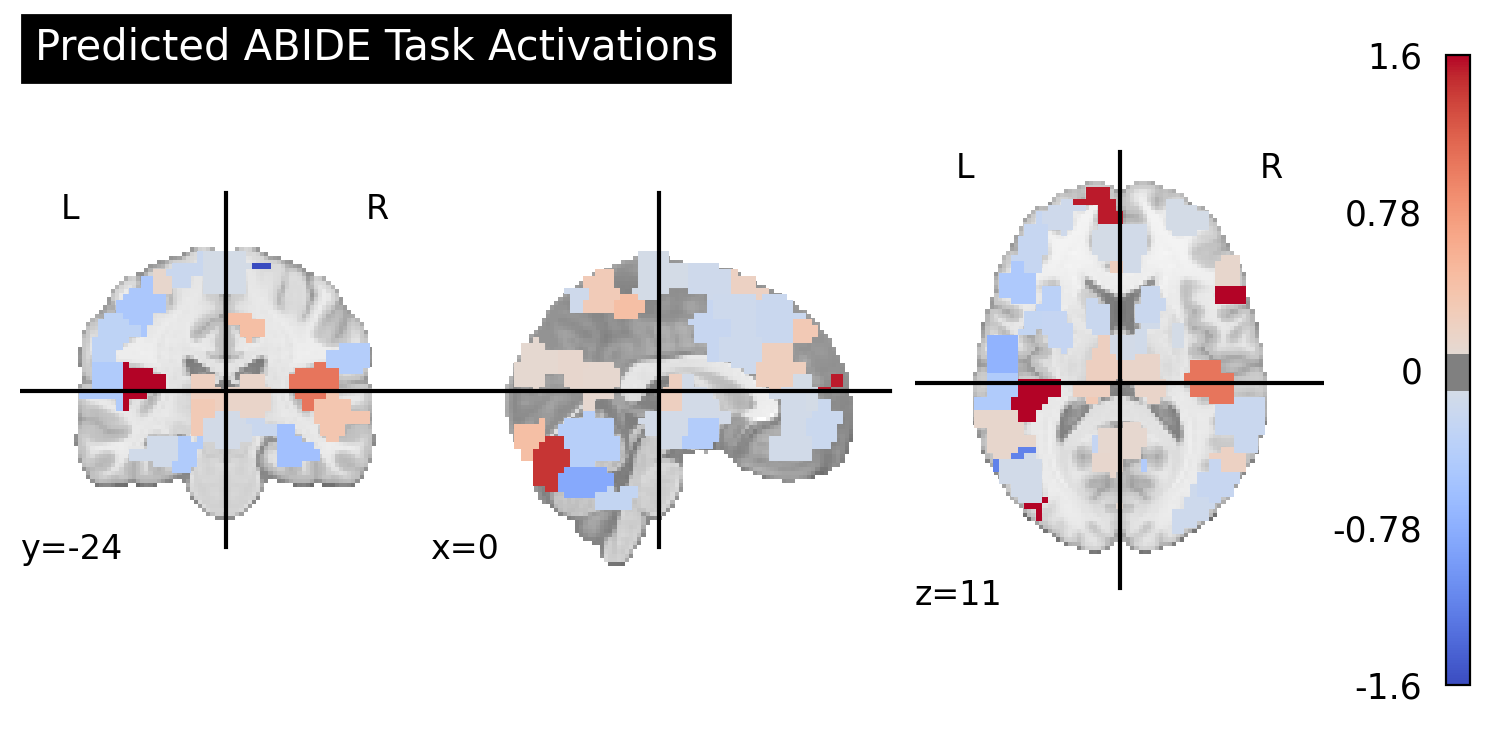

In [ ]:
# ABIDE

# Convert stat map to a NifTI image
abide_stat_img = image.new_img_like(atlas_img, abide_stat_map)

# Display the ABIDE task activation
plotting.plot_stat_map(
    abide_stat_img,
    title="Predicted ABIDE Task Activations",
    cmap="coolwarm",
    threshold=0.1,
    vmax=vmax, vmin=vmin,
    colorbar=True
)
plotting.show()


In [ ]:
print("HCP Task Activation - Min:", np.min(hcp_social_task_mean_z), "Max:", np.max(hcp_social_task_mean_z))
print("ABIDE Task Activation - Min:", np.min(abide_task_mean_avg_z), "Max:", np.max(abide_task_mean_avg_z))


HCP Task Activation - Min: -3.4308765 Max: 1.3989353
ABIDE Task Activation - Min: -1.555967932619028 Max: 1.555967932619028
